# The prediction of concrete compressive strenght with ML (Kaggle dataset)

In [2]:
#Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, Lasso, ElasticNet
from xgboost import XGBRegressor

#additional libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import missingno as msno  #checking for missing values
from statsmodels.stats.outliers_influence import variance_inflation_factor  #checking for multicollinearity

In [3]:
# we first read the dataset
import os
ROOT_DIR = os.path.realpath(os.path.join(os.path.dirname('data'), '..'))

dataset = pd.read_excel(os.path.join(ROOT_DIR, 'data', 'nConcrete_Data.xls'))
print ('The Shape of Dataset: ',dataset.shape)
dataset.head()

The Shape of Dataset:  (1030, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
# to work with data we should see how many categorical and numerical features we have
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']
print(f'Number of Numerical Features are {len(numerical_features)}')

Number of Numerical Features are 9


In [5]:
categorical_features = [feature for feature in dataset.columns if dataset[feature].dtypes == 'O']
print(f'Number of Categorical Features are {len(categorical_features)}')

Number of Categorical Features are 0


In [6]:
# in order to simplify the process, we change the names of the column headers
columns={'Cement (component 1)(kg in a m^3 mixture)':'cement',
        'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'blast_furnace_slag',
        'Fly Ash (component 3)(kg in a m^3 mixture)':'fly_ash',
        'Water  (component 4)(kg in a m^3 mixture)':'water',
        'Superplasticizer (component 5)(kg in a m^3 mixture)':'superplasticizer',
        'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':'coarse_aggregate',
        'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fine_aggregate',
        'Age (day)':'age','Concrete compressive strength(MPa, megapascals) ':'concrete_compressive_strength'}
dataset.rename(columns=columns,inplace=True)
dataset.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


<AxesSubplot:>

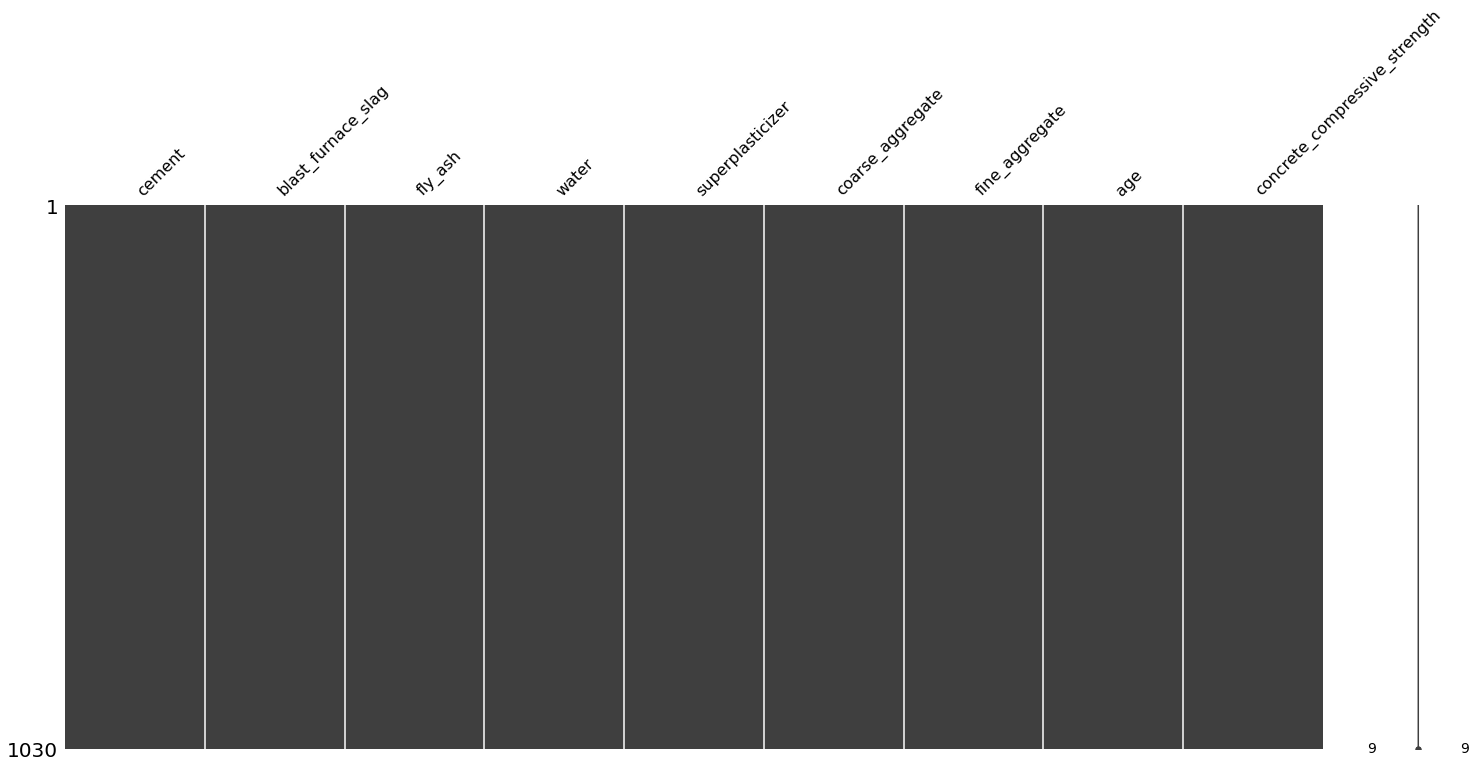

In [7]:
# checking for missing data
msno.matrix(dataset)

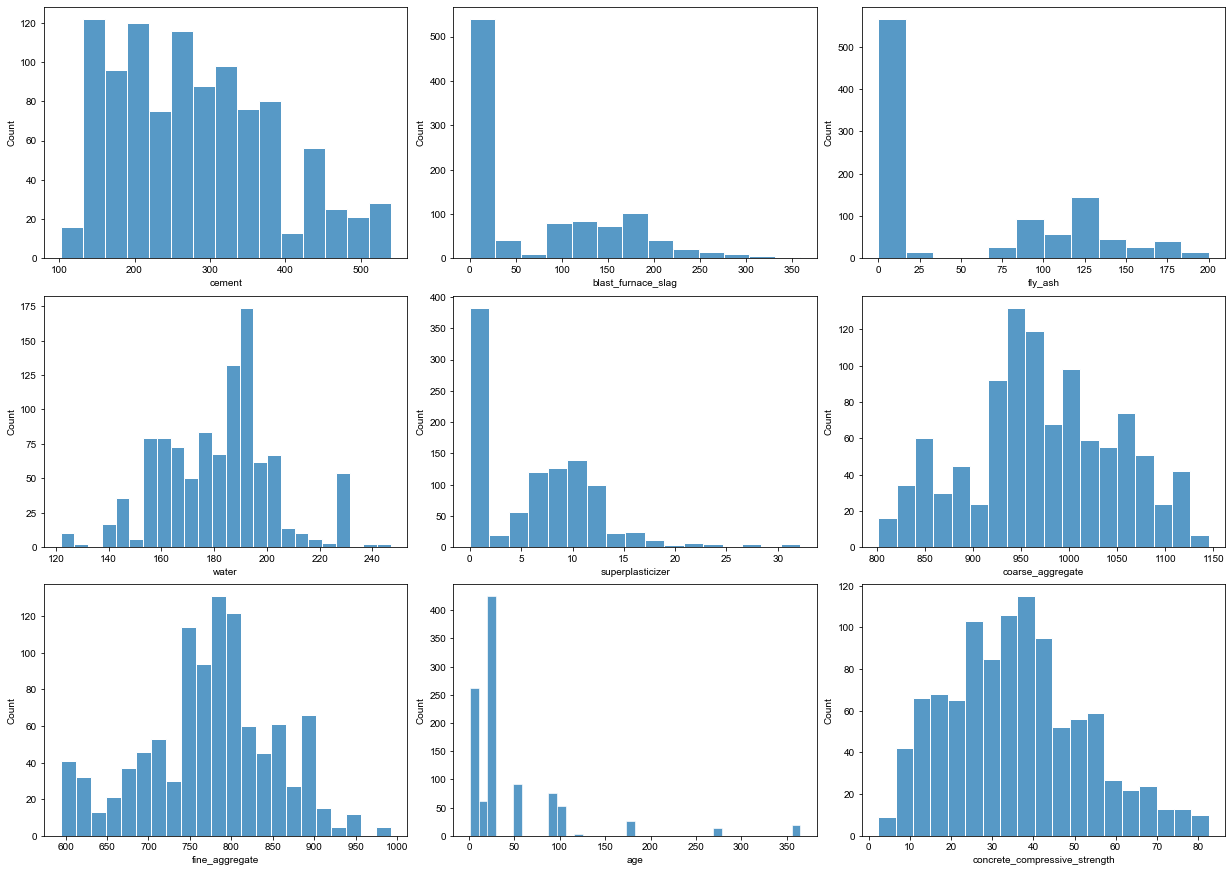

In [8]:
# see the histograms in order to compare with normal distribution
fig, ax = plt.subplots(3,3, figsize=(17,12), constrained_layout=True)
ax=ax.flatten()
sns.set_style("darkgrid")
for num, col in enumerate(dataset.columns):
    sns.histplot(dataset[col], ax=ax[num])
plt.show()

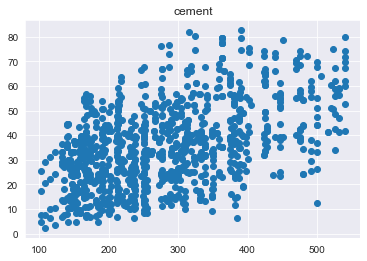

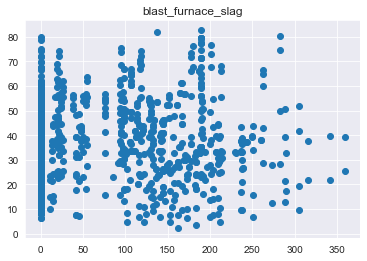

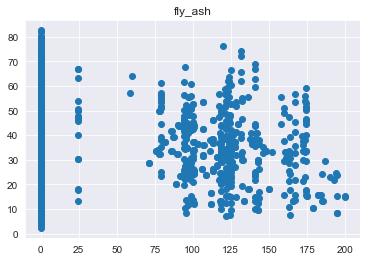

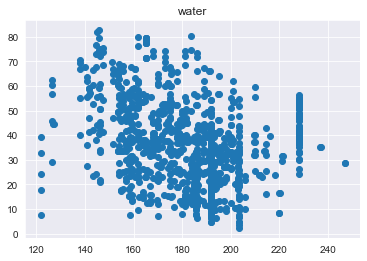

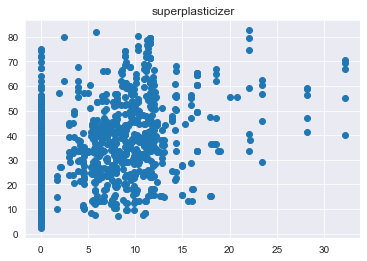

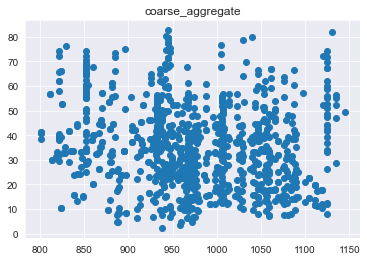

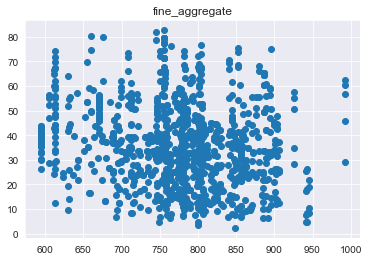

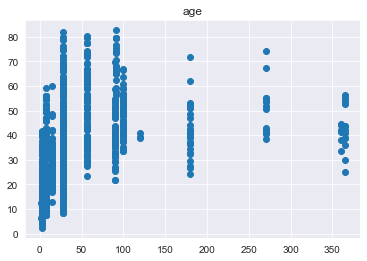

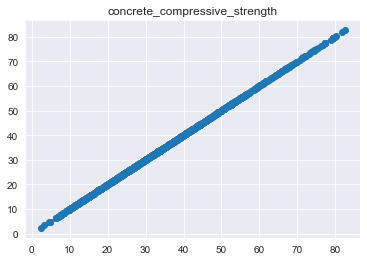

In [9]:
# let's see the relationship between SalePrice and these continuous variales
for feature in dataset:
    data = dataset.copy()
    plt.scatter(data[feature],data['concrete_compressive_strength'])
    plt.title(feature)
    plt.show()

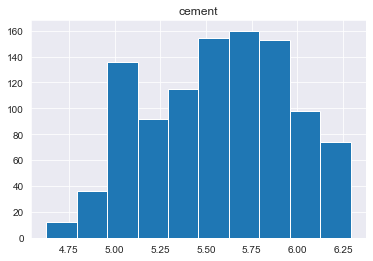

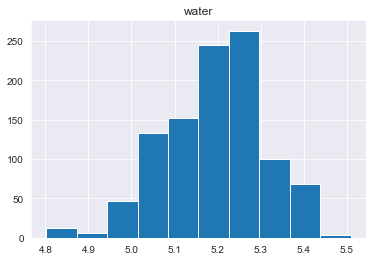

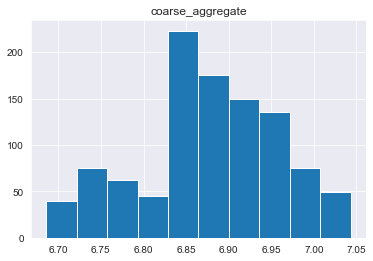

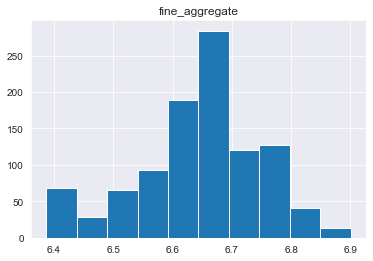

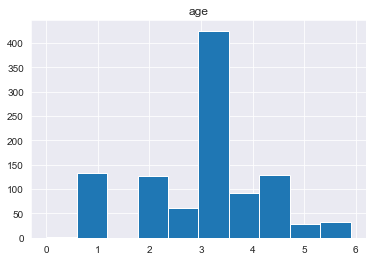

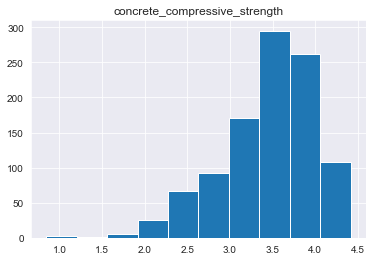

In [10]:
# we observe that some of the features don't follow the gaussian distribution. We can apply log transformation further
for feature in dataset:
    data = dataset.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature] = np.log(data[feature])
        data[feature].hist()
        plt.title(feature)
        plt.show()

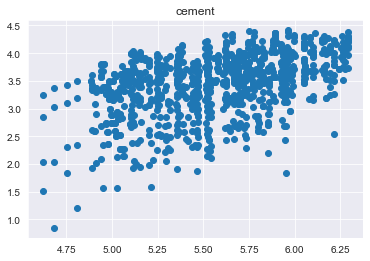

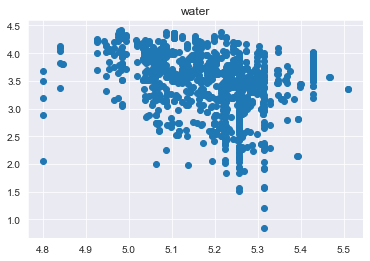

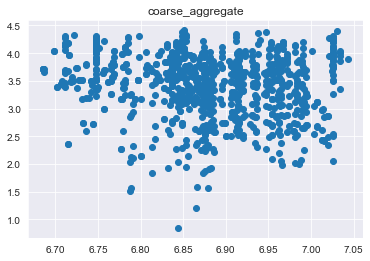

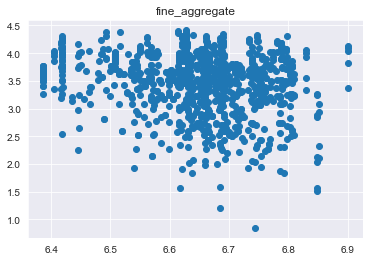

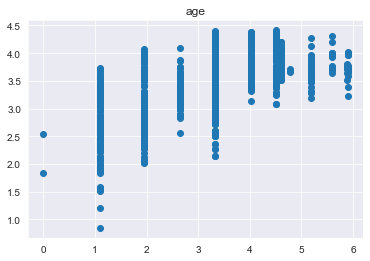

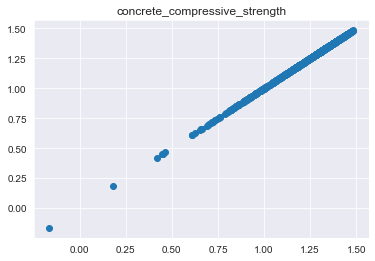

In [11]:
# let's see the relationship between SalePrice and these continuous variales after transformation

for feature in dataset:
    data = dataset.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature] = np.log(data[feature])
        data['concrete_compressive_strength'] = np.log(data['concrete_compressive_strength'])
        plt.scatter(data[feature],data['concrete_compressive_strength'])
        plt.title(feature)
        plt.show()

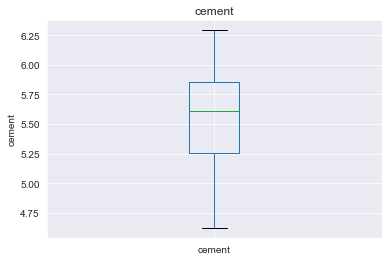

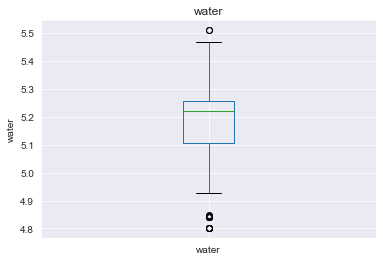

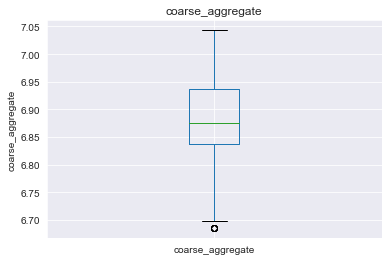

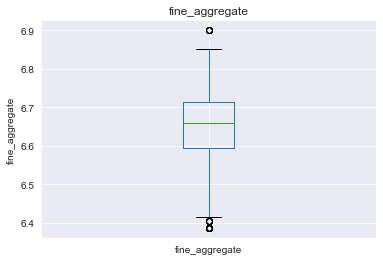

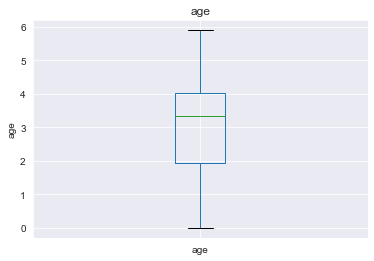

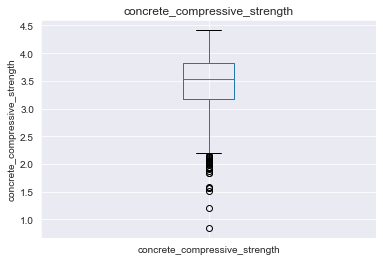

In [12]:
# outliers detection through boxplots
for feature in dataset:
    data= dataset.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature]=np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

In [13]:
# we see that features generally do not have many outliers, but target does
## let's check the target for normality 
### we can use the Shapiro-Wilk test. 
#### The null hypothesis (H0) states that the variable is normally distributed, and the alternative hypothesis (H1) states that the variable is NOT normally distributed.

from scipy.stats import shapiro
def check_normality(data):
    stat, p = shapiro(data)
    print("stat = %.2f, P-Value = %.2f" % (stat, p))
    if p > 0.05:
        print("Normal Distribution")
    else:
        print("Not Normal.")

check_normality(dataset['concrete_compressive_strength'])

stat = 0.98, P-Value = 0.00
Not Normal.


In [14]:
# the same after log transformation
check_normality(np.log(dataset['concrete_compressive_strength']))

stat = 0.95, P-Value = 0.00
Not Normal.


In [15]:
# check for zero values in variables
dataset.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


<AxesSubplot:>

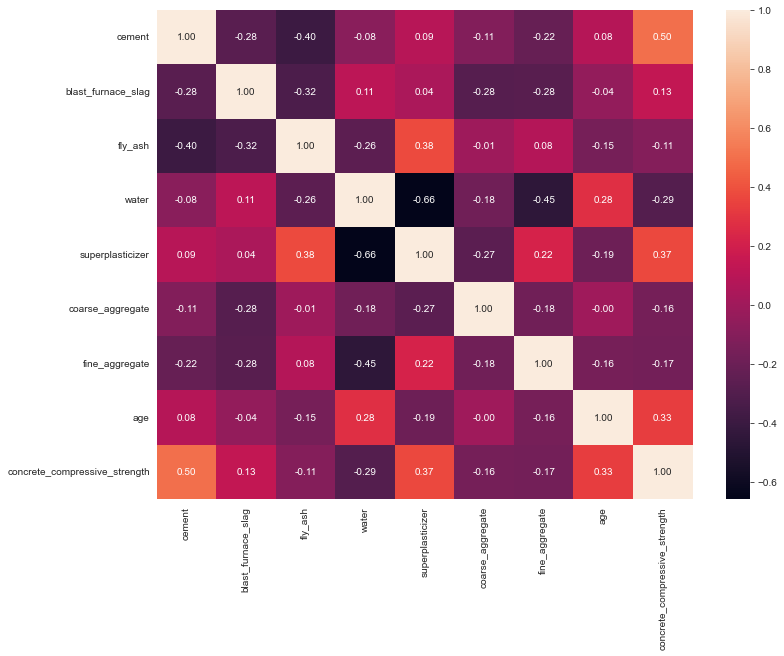

In [16]:
# basically, we don't make our data look like a gaussian distribution with log transformation, so we won't transform variables
## let's see the correlation matrix
plt.figure(figsize=(12,9))
sns.heatmap(dataset.corr(), annot=True, fmt='.2f')

In [17]:
# correlation between concrete_compressive_strength(label) and the rest (features)
corr=dataset.corr()
corr['concrete_compressive_strength']
correlation_df=pd.Series(corr['concrete_compressive_strength']).to_frame()
correlation_df.sort_values(by='concrete_compressive_strength',ascending=False)

,concrete_compressive_strength
concrete_compressive_strength,1.000000
cement,0.497833
superplasticizer,0.366102
age,0.328877
blast_furnace_slag,0.134824
fly_ash,-0.105753
coarse_aggregate,-0.164928
fine_aggregate,-0.167249
water,-0.289613


In [18]:
# we should also check data for multicollinearity
## VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.drop('concrete_compressive_strength', axis=1).columns
  
### calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(dataset.drop('concrete_compressive_strength', axis=1).values, i)
                          for i in range(len(dataset.drop('concrete_compressive_strength', axis=1).columns))]

In [19]:
vif_data

,feature,VIF
0,cement,15.468620
1,blast_furnace_slag,3.330359
2,fly_ash,4.148893
3,water,82.150840
4,superplasticizer,5.472391
5,coarse_aggregate,84.959460
6,fine_aggregate,72.795397
7,age,1.699430


In [20]:
# basically we see, that for several features VIF is higher than 8-10, so some of them should be eliminated
dataset = dataset.drop('coarse_aggregate', axis = 1)

In [21]:
# restate VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.drop('concrete_compressive_strength', axis=1).columns
vif_data["VIF"] = [variance_inflation_factor(dataset.drop('concrete_compressive_strength', axis=1).values, i)
                          for i in range(len(dataset.drop('concrete_compressive_strength', axis=1).columns))]

In [22]:
vif_data

,feature,VIF
0,cement,14.493827
1,blast_furnace_slag,3.299359
2,fly_ash,3.963502
3,water,72.103099
4,superplasticizer,5.396163
5,fine_aggregate,48.612705
6,age,1.699314


In [23]:
dataset = dataset.drop('water', axis = 1)

In [24]:
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.drop('concrete_compressive_strength', axis=1).columns
vif_data["VIF"] = [variance_inflation_factor(dataset.drop('concrete_compressive_strength', axis=1).values, i)
                          for i in range(len(dataset.drop('concrete_compressive_strength', axis=1).columns))]

In [25]:
vif_data

,feature,VIF
0,cement,9.424557
1,blast_furnace_slag,2.081062
2,fly_ash,2.943828
3,superplasticizer,2.939740
4,fine_aggregate,14.219531
5,age,1.577358


In [26]:
dataset = dataset.drop('fine_aggregate', axis = 1)

In [27]:
# restate VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.drop('concrete_compressive_strength', axis=1).columns
vif_data["VIF"] = [variance_inflation_factor(dataset.drop('concrete_compressive_strength', axis=1).values, i)
                          for i in range(len(dataset.drop('concrete_compressive_strength', axis=1).columns))]

In [28]:
# no we don't have multicollinaerity
vif_data

,feature,VIF
0,cement,2.819901
1,blast_furnace_slag,1.526244
2,fly_ash,1.878603
3,superplasticizer,2.921422
4,age,1.550460


In [29]:
# let's split the dataset to train and test datasets
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('concrete_compressive_strength', axis=1), dataset['concrete_compressive_strength'] , test_size=0.25, random_state=101)

In [30]:
X_train

,cement,blast_furnace_slag,fly_ash,superplasticizer,age
174,401.80,94.70,0.00,11.40,91
228,167.95,42.08,163.83,5.72,100
961,336.50,0.00,0.00,3.40,28
550,393.00,0.00,0.00,0.00,7
1005,252.10,97.10,75.60,8.30,28
...,...,...,...,...,...
575,238.10,0.00,0.00,0.00,28
973,143.80,136.30,106.20,7.50,28
75,475.00,118.80,0.00,8.90,3
599,339.00,0.00,0.00,0.00,7


In [31]:
y_train

174     75.497622
228     39.231184
961     44.868340
550     27.742446
1005    33.399596
          ...    
575     17.576122
973     26.147688
75      37.797074
599     20.966965
863     42.133878
Name: concrete_compressive_strength, Length: 772, dtype: float64

In [32]:
X_test

,cement,blast_furnace_slag,fly_ash,superplasticizer,age
605,236.00,0.00,0.00,0.00,3
572,220.80,147.20,0.00,0.00,7
920,136.00,162.00,126.00,10.00,28
921,155.00,0.00,143.00,9.00,28
74,375.00,93.80,0.00,23.40,3
...,...,...,...,...,...
557,255.50,170.30,0.00,0.00,7
514,424.00,22.00,132.00,8.92,56
360,218.23,54.64,123.78,11.91,14
959,312.90,160.50,0.00,9.60,28


In [33]:
y_test

605     6.467285
572    13.089012
920    29.068308
921     9.735401
74     28.999361
         ...    
557    17.236211
514    74.364911
360    35.956173
959    52.446371
471    57.026560
Name: concrete_compressive_strength, Length: 258, dtype: float64

In [34]:
# scaling the data
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train) 
X_test=scaler.fit_transform(X_test) 

In [35]:
X_train

array([[ 1.14109892,  0.25622233, -0.8447934 ,  0.87494949,  0.74620673],
       [-1.08460979, -0.35986474,  1.73464242, -0.07090197,  0.89350613],
       [ 0.51959463, -0.85254706, -0.8447934 , -0.45723567, -0.28488909],
       ...,
       [ 1.83779286,  0.53839068, -0.8447934 ,  0.45864163, -0.69405409],
       [ 0.54338882, -0.85254706, -0.8447934 , -1.02341437, -0.62858769],
       [ 0.05798731,  0.56414878, -0.8447934 ,  0.14224765, -0.28488909]])

In [36]:
X_test

array([[-0.41868529, -0.87060998, -0.85451815, -1.08735321, -0.63050313],
       [-0.5668716 ,  0.7910183 , -0.85451815, -1.08735321, -0.57242751],
       [-1.39359526,  0.95808418,  1.07586629,  0.61838807, -0.26753051],
       ...,
       [-0.59192679, -0.25382079,  1.04185475,  0.94418466, -0.47079518],
       [ 0.33102048,  0.94115183, -0.85451815,  0.55015842, -0.26753051],
       [ 1.62862564, -0.59969233,  0.35580225,  0.89301242, -0.26753051]])

In [37]:
# develop a function for evaluating the model
## basically, here we state some metrics for evaluating regression-problem models (errors and R squared)
### also here we define a function for cross-validation (specifying cv here means simple Kfold with number of folds equal to 10)

def print_evaluate(true, predicted):
    mae=np.round(mean_absolute_error(true, predicted),3)
    mse=np.round(mean_squared_error(true, predicted),3)
    rmse=np.round(np.sqrt(mean_squared_error(true, predicted)),3)
    r2_square=np.round(r2_score(true, predicted),3)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)
    print('R2 Score:', r2_square)

def cross_val(model, X, y):
    pred=cross_val_score(model, X,y,cv=10)
    return np.round(pred.mean(),3)

def evaluate(true, predicted):
    mae=np.round(mean_absolute_error(true, predicted),3)
    mse=np.round(mean_squared_error(true, predicted),3)
    rmse=np.round(np.sqrt(mean_squared_error(true, predicted)),3)
    r2_square=np.round(r2_score(true, predicted),3)
    
    return mae,mse,rmse,r2_square 
    

In [38]:
# now we start trying different models
# linear regression algorithm
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [39]:
# predict target and cros-validation function call
train_pred = lin_reg.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(lin_reg, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  8.457
MSE:  112.905
RMSE:  10.626
R2 Score: 0.575
--------------------------------

Cross_validation score:



0.561

In [40]:
results_df=pd.DataFrame(data=[['Linear Regression', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561


In [41]:
# elactic net
el=ElasticNet()
el.fit(X_train, y_train)

train_pred=el.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(el, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  9.657
MSE:  144.625
RMSE:  12.026
R2 Score: 0.456
--------------------------------

Cross_validation score:



0.448

In [42]:
results_df=results_df.append(pd.DataFrame(data=[['Elastic net', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448


In [43]:
# lasso
lasso=Lasso()
lasso.fit(X_train, y_train)

train_pred=lasso.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(lasso, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  8.9
MSE:  123.802
RMSE:  11.127
R2 Score: 0.534
--------------------------------

Cross_validation score:



0.524

In [44]:
results_df=results_df.append(pd.DataFrame(data=[['lasso', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524


In [45]:
# ridge
ridge=Ridge(alpha=0.001)
ridge.fit(X_train, y_train)

train_pred=ridge.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(ridge, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  8.457
MSE:  112.905
RMSE:  10.626
R2 Score: 0.575
--------------------------------

Cross_validation score:



0.561

In [46]:
results_df=results_df.append(pd.DataFrame(data=[['ridge', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524
3,ridge,8.457,112.905,10.626,0.575,0.561


In [47]:
# polinomial regression
from sklearn.preprocessing import PolynomialFeatures
poly_reg=PolynomialFeatures(degree=2)

X_train_2_d=poly_reg.fit_transform(X_train)

lin_reg=LinearRegression()
lin_reg.fit(X_train_2_d, y_train)

train_pred=lin_reg.predict(X_train_2_d)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(el, X_train_2_d, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  6.239
MSE:  65.888
RMSE:  8.117
R2 Score: 0.752
--------------------------------

Cross_validation score:



0.484

In [48]:
results_df=results_df.append(pd.DataFrame(data=[['polynomial', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524
3,ridge,8.457,112.905,10.626,0.575,0.561
4,polynomial,6.239,65.888,8.117,0.752,0.484


In [49]:
# random forest regressor
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor()
rfr.fit(X_train, y_train)

train_pred=rfr.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(rfr, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  1.466
MSE:  4.461
RMSE:  2.112
R2 Score: 0.983
--------------------------------

Cross_validation score:



0.888

In [50]:
results_df=results_df.append(pd.DataFrame(data=[['Random forest regressor', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524
3,ridge,8.457,112.905,10.626,0.575,0.561
4,polynomial,6.239,65.888,8.117,0.752,0.484
5,Random forest regressor,1.466,4.461,2.112,0.983,0.888


In [51]:
# SGDR regressor
lr = SGDRegressor()
lr.fit(X_train, y_train)

train_pred=lr.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(lr, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  8.457
MSE:  112.908
RMSE:  10.626
R2 Score: 0.575
--------------------------------

Cross_validation score:



0.56

In [52]:
results_df=results_df.append(pd.DataFrame(data=[['SGDR regressor', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524
3,ridge,8.457,112.905,10.626,0.575,0.561
4,polynomial,6.239,65.888,8.117,0.752,0.484
5,Random forest regressor,1.466,4.461,2.112,0.983,0.888
6,SGDR regressor,8.457,112.908,10.626,0.575,0.560


In [53]:
# gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train, y_train)

train_pred=gbrt.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(gbrt, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  3.281
MSE:  19.243
RMSE:  4.387
R2 Score: 0.928
--------------------------------

Cross_validation score:



0.873

In [54]:
results_df=results_df.append(pd.DataFrame(data=[['Gradient boosting regressor', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524
3,ridge,8.457,112.905,10.626,0.575,0.561
4,polynomial,6.239,65.888,8.117,0.752,0.484
5,Random forest regressor,1.466,4.461,2.112,0.983,0.888
6,SGDR regressor,8.457,112.908,10.626,0.575,0.560
7,Gradient boosting regressor,3.281,19.243,4.387,0.928,0.873


In [55]:
# Train an XGBoost regressor model 
import xgboost as xgb
xb = xgb.XGBRegressor()
xb.fit(X_train, y_train)

train_pred=xb.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(xb, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  0.694
MSE:  1.284
RMSE:  1.133
R2 Score: 0.995
--------------------------------

Cross_validation score:



0.906

In [56]:
results_df=results_df.append(pd.DataFrame(data=[['XGB regressor', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524
3,ridge,8.457,112.905,10.626,0.575,0.561
4,polynomial,6.239,65.888,8.117,0.752,0.484
5,Random forest regressor,1.466,4.461,2.112,0.983,0.888
6,SGDR regressor,8.457,112.908,10.626,0.575,0.560
7,Gradient boosting regressor,3.281,19.243,4.387,0.928,0.873
8,XGB regressor,0.694,1.284,1.133,0.995,0.906


In [57]:
# LGBM regressor
lb = lgb.LGBMRegressor()
lb.fit(X_train, y_train)

train_pred=lb.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(lb, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Train set evaluation:

MAE:  2.08
MSE:  8.637
RMSE:  2.939
R2 Score: 0.967
--------------------------------

Cross_validation score:



0.899

In [58]:
results_df=results_df.append(pd.DataFrame(data=[['LGBM regressor', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524
3,ridge,8.457,112.905,10.626,0.575,0.561
4,polynomial,6.239,65.888,8.117,0.752,0.484
5,Random forest regressor,1.466,4.461,2.112,0.983,0.888
6,SGDR regressor,8.457,112.908,10.626,0.575,0.560
7,Gradient boosting regressor,3.281,19.243,4.387,0.928,0.873
8,XGB regressor,0.694,1.284,1.133,0.995,0.906
9,LGBM regressor,2.080,8.637,2.939,0.967,0.899


In [59]:
# Catboost regressor
cb = CatBoostRegressor()
cb.fit(X_train, y_train)

train_pred=cb.predict(X_train)

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')
cross_score=cross_val(cb, X_train, y_train)
print('Cross_validation score:\n')
cross_score

Learning rate set to 0.039303
0:	learn: 15.9191592	total: 151ms	remaining: 2m 30s
1:	learn: 15.5442072	total: 152ms	remaining: 1m 16s
2:	learn: 15.2126796	total: 154ms	remaining: 51.2s
3:	learn: 14.9113958	total: 156ms	remaining: 38.8s
4:	learn: 14.5928159	total: 157ms	remaining: 31.3s
5:	learn: 14.2655780	total: 159ms	remaining: 26.3s
6:	learn: 13.9679654	total: 160ms	remaining: 22.8s
7:	learn: 13.6896913	total: 162ms	remaining: 20.1s
8:	learn: 13.4091483	total: 164ms	remaining: 18.1s
9:	learn: 13.1291997	total: 166ms	remaining: 16.5s
10:	learn: 12.8853588	total: 168ms	remaining: 15.1s
11:	learn: 12.6153406	total: 170ms	remaining: 14s
12:	learn: 12.3717166	total: 171ms	remaining: 13s
13:	learn: 12.1571594	total: 173ms	remaining: 12.2s
14:	learn: 11.9221557	total: 174ms	remaining: 11.4s
15:	learn: 11.7119491	total: 176ms	remaining: 10.8s
16:	learn: 11.4988902	total: 178ms	remaining: 10.3s
17:	learn: 11.2926025	total: 180ms	remaining: 9.82s
18:	learn: 11.1010137	total: 182ms	remaining: 

218:	learn: 4.5299532	total: 492ms	remaining: 1.75s
219:	learn: 4.5234967	total: 494ms	remaining: 1.75s
220:	learn: 4.5193532	total: 496ms	remaining: 1.75s
221:	learn: 4.5159976	total: 498ms	remaining: 1.74s
222:	learn: 4.5145614	total: 499ms	remaining: 1.74s
223:	learn: 4.5106852	total: 500ms	remaining: 1.73s
224:	learn: 4.5058841	total: 502ms	remaining: 1.73s
225:	learn: 4.5026297	total: 503ms	remaining: 1.72s
226:	learn: 4.4981928	total: 505ms	remaining: 1.72s
227:	learn: 4.4953877	total: 507ms	remaining: 1.72s
228:	learn: 4.4940055	total: 508ms	remaining: 1.71s
229:	learn: 4.4888472	total: 510ms	remaining: 1.71s
230:	learn: 4.4814080	total: 512ms	remaining: 1.7s
231:	learn: 4.4763438	total: 513ms	remaining: 1.7s
232:	learn: 4.4734724	total: 515ms	remaining: 1.69s
233:	learn: 4.4696525	total: 516ms	remaining: 1.69s
234:	learn: 4.4637299	total: 518ms	remaining: 1.69s
235:	learn: 4.4603791	total: 520ms	remaining: 1.68s
236:	learn: 4.4572933	total: 521ms	remaining: 1.68s
237:	learn: 4.

425:	learn: 3.6718877	total: 830ms	remaining: 1.12s
426:	learn: 3.6682499	total: 832ms	remaining: 1.12s
427:	learn: 3.6637435	total: 834ms	remaining: 1.11s
428:	learn: 3.6595861	total: 836ms	remaining: 1.11s
429:	learn: 3.6580475	total: 837ms	remaining: 1.11s
430:	learn: 3.6534663	total: 839ms	remaining: 1.11s
431:	learn: 3.6505980	total: 841ms	remaining: 1.1s
432:	learn: 3.6483992	total: 842ms	remaining: 1.1s
433:	learn: 3.6474416	total: 844ms	remaining: 1.1s
434:	learn: 3.6440770	total: 846ms	remaining: 1.1s
435:	learn: 3.6411526	total: 848ms	remaining: 1.1s
436:	learn: 3.6402632	total: 850ms	remaining: 1.09s
437:	learn: 3.6377728	total: 851ms	remaining: 1.09s
438:	learn: 3.6333194	total: 853ms	remaining: 1.09s
439:	learn: 3.6298481	total: 854ms	remaining: 1.09s
440:	learn: 3.6242649	total: 856ms	remaining: 1.08s
441:	learn: 3.6213671	total: 857ms	remaining: 1.08s
442:	learn: 3.6170869	total: 859ms	remaining: 1.08s
443:	learn: 3.6131558	total: 860ms	remaining: 1.08s
444:	learn: 3.610

652:	learn: 3.0862305	total: 1.17s	remaining: 622ms
653:	learn: 3.0843857	total: 1.17s	remaining: 621ms
654:	learn: 3.0832973	total: 1.17s	remaining: 619ms
655:	learn: 3.0813814	total: 1.18s	remaining: 617ms
656:	learn: 3.0769470	total: 1.18s	remaining: 615ms
657:	learn: 3.0736300	total: 1.18s	remaining: 613ms
658:	learn: 3.0709938	total: 1.18s	remaining: 611ms
659:	learn: 3.0690022	total: 1.18s	remaining: 609ms
660:	learn: 3.0668714	total: 1.18s	remaining: 607ms
661:	learn: 3.0660304	total: 1.19s	remaining: 605ms
662:	learn: 3.0632999	total: 1.19s	remaining: 604ms
663:	learn: 3.0612433	total: 1.19s	remaining: 602ms
664:	learn: 3.0592163	total: 1.19s	remaining: 600ms
665:	learn: 3.0544196	total: 1.19s	remaining: 598ms
666:	learn: 3.0511777	total: 1.19s	remaining: 596ms
667:	learn: 3.0487376	total: 1.2s	remaining: 594ms
668:	learn: 3.0478383	total: 1.2s	remaining: 592ms
669:	learn: 3.0465676	total: 1.2s	remaining: 590ms
670:	learn: 3.0446203	total: 1.2s	remaining: 588ms
671:	learn: 3.04

878:	learn: 2.6929382	total: 1.5s	remaining: 207ms
879:	learn: 2.6919891	total: 1.5s	remaining: 205ms
880:	learn: 2.6907597	total: 1.51s	remaining: 204ms
881:	learn: 2.6898964	total: 1.51s	remaining: 202ms
882:	learn: 2.6872756	total: 1.51s	remaining: 200ms
883:	learn: 2.6856663	total: 1.51s	remaining: 198ms
884:	learn: 2.6837368	total: 1.51s	remaining: 197ms
885:	learn: 2.6830037	total: 1.51s	remaining: 195ms
886:	learn: 2.6819474	total: 1.52s	remaining: 193ms
887:	learn: 2.6788512	total: 1.52s	remaining: 192ms
888:	learn: 2.6779875	total: 1.52s	remaining: 190ms
889:	learn: 2.6770083	total: 1.52s	remaining: 188ms
890:	learn: 2.6761913	total: 1.52s	remaining: 187ms
891:	learn: 2.6760430	total: 1.53s	remaining: 185ms
892:	learn: 2.6740914	total: 1.53s	remaining: 183ms
893:	learn: 2.6723683	total: 1.53s	remaining: 182ms
894:	learn: 2.6717819	total: 1.53s	remaining: 180ms
895:	learn: 2.6701862	total: 1.53s	remaining: 178ms
896:	learn: 2.6685833	total: 1.53s	remaining: 176ms
897:	learn: 2.

68:	learn: 6.3182531	total: 111ms	remaining: 1.5s
69:	learn: 6.2796187	total: 113ms	remaining: 1.5s
70:	learn: 6.2489690	total: 115ms	remaining: 1.5s
71:	learn: 6.2103144	total: 116ms	remaining: 1.5s
72:	learn: 6.1666312	total: 118ms	remaining: 1.5s
73:	learn: 6.1293925	total: 119ms	remaining: 1.49s
74:	learn: 6.1032617	total: 121ms	remaining: 1.49s
75:	learn: 6.0646939	total: 123ms	remaining: 1.49s
76:	learn: 6.0376920	total: 124ms	remaining: 1.49s
77:	learn: 6.0089199	total: 126ms	remaining: 1.49s
78:	learn: 5.9753318	total: 127ms	remaining: 1.49s
79:	learn: 5.9427440	total: 129ms	remaining: 1.48s
80:	learn: 5.9218436	total: 131ms	remaining: 1.48s
81:	learn: 5.8871555	total: 132ms	remaining: 1.48s
82:	learn: 5.8674644	total: 134ms	remaining: 1.48s
83:	learn: 5.8460266	total: 135ms	remaining: 1.48s
84:	learn: 5.8313611	total: 137ms	remaining: 1.47s
85:	learn: 5.8093175	total: 138ms	remaining: 1.47s
86:	learn: 5.7864013	total: 140ms	remaining: 1.47s
87:	learn: 5.7695848	total: 141ms	re

291:	learn: 4.1218550	total: 440ms	remaining: 1.07s
292:	learn: 4.1111476	total: 442ms	remaining: 1.07s
293:	learn: 4.1100367	total: 443ms	remaining: 1.06s
294:	learn: 4.1084099	total: 445ms	remaining: 1.06s
295:	learn: 4.1070787	total: 446ms	remaining: 1.06s
296:	learn: 4.1055459	total: 448ms	remaining: 1.06s
297:	learn: 4.0975904	total: 449ms	remaining: 1.06s
298:	learn: 4.0898086	total: 451ms	remaining: 1.06s
299:	learn: 4.0829127	total: 452ms	remaining: 1.05s
300:	learn: 4.0761207	total: 454ms	remaining: 1.05s
301:	learn: 4.0753525	total: 455ms	remaining: 1.05s
302:	learn: 4.0698999	total: 457ms	remaining: 1.05s
303:	learn: 4.0635303	total: 458ms	remaining: 1.05s
304:	learn: 4.0603986	total: 460ms	remaining: 1.05s
305:	learn: 4.0598596	total: 461ms	remaining: 1.04s
306:	learn: 4.0539287	total: 463ms	remaining: 1.04s
307:	learn: 4.0497404	total: 464ms	remaining: 1.04s
308:	learn: 4.0492156	total: 466ms	remaining: 1.04s
309:	learn: 4.0475000	total: 468ms	remaining: 1.04s
310:	learn: 

463:	learn: 3.4941556	total: 764ms	remaining: 882ms
464:	learn: 3.4920141	total: 766ms	remaining: 881ms
465:	learn: 3.4897416	total: 769ms	remaining: 881ms
466:	learn: 3.4868201	total: 771ms	remaining: 880ms
467:	learn: 3.4846645	total: 773ms	remaining: 878ms
468:	learn: 3.4821773	total: 774ms	remaining: 877ms
469:	learn: 3.4791948	total: 776ms	remaining: 875ms
470:	learn: 3.4755239	total: 777ms	remaining: 873ms
471:	learn: 3.4742462	total: 779ms	remaining: 871ms
472:	learn: 3.4699735	total: 780ms	remaining: 870ms
473:	learn: 3.4676607	total: 783ms	remaining: 869ms
474:	learn: 3.4629469	total: 785ms	remaining: 868ms
475:	learn: 3.4624670	total: 787ms	remaining: 866ms
476:	learn: 3.4583164	total: 788ms	remaining: 865ms
477:	learn: 3.4563578	total: 791ms	remaining: 864ms
478:	learn: 3.4545893	total: 794ms	remaining: 863ms
479:	learn: 3.4534955	total: 795ms	remaining: 862ms
480:	learn: 3.4505062	total: 798ms	remaining: 861ms
481:	learn: 3.4488329	total: 800ms	remaining: 859ms
482:	learn: 

662:	learn: 3.0220630	total: 1.09s	remaining: 556ms
663:	learn: 3.0202367	total: 1.1s	remaining: 555ms
664:	learn: 3.0181902	total: 1.1s	remaining: 553ms
665:	learn: 3.0172275	total: 1.1s	remaining: 552ms
666:	learn: 3.0163393	total: 1.1s	remaining: 550ms
667:	learn: 3.0154481	total: 1.1s	remaining: 548ms
668:	learn: 3.0115595	total: 1.1s	remaining: 547ms
669:	learn: 3.0102932	total: 1.11s	remaining: 545ms
670:	learn: 3.0088080	total: 1.11s	remaining: 544ms
671:	learn: 3.0076927	total: 1.11s	remaining: 542ms
672:	learn: 3.0058936	total: 1.11s	remaining: 541ms
673:	learn: 3.0042783	total: 1.11s	remaining: 539ms
674:	learn: 3.0008152	total: 1.11s	remaining: 537ms
675:	learn: 2.9996951	total: 1.12s	remaining: 536ms
676:	learn: 2.9984399	total: 1.12s	remaining: 535ms
677:	learn: 2.9948999	total: 1.12s	remaining: 533ms
678:	learn: 2.9898536	total: 1.12s	remaining: 531ms
679:	learn: 2.9892347	total: 1.13s	remaining: 529ms
680:	learn: 2.9879542	total: 1.13s	remaining: 528ms
681:	learn: 2.9867

862:	learn: 2.6861351	total: 1.43s	remaining: 226ms
863:	learn: 2.6856581	total: 1.43s	remaining: 225ms
864:	learn: 2.6848341	total: 1.43s	remaining: 223ms
865:	learn: 2.6833346	total: 1.43s	remaining: 222ms
866:	learn: 2.6822785	total: 1.43s	remaining: 220ms
867:	learn: 2.6811565	total: 1.43s	remaining: 218ms
868:	learn: 2.6799019	total: 1.44s	remaining: 217ms
869:	learn: 2.6791678	total: 1.44s	remaining: 215ms
870:	learn: 2.6780927	total: 1.44s	remaining: 213ms
871:	learn: 2.6750397	total: 1.44s	remaining: 212ms
872:	learn: 2.6735298	total: 1.44s	remaining: 210ms
873:	learn: 2.6725900	total: 1.44s	remaining: 208ms
874:	learn: 2.6718995	total: 1.45s	remaining: 207ms
875:	learn: 2.6703707	total: 1.45s	remaining: 205ms
876:	learn: 2.6698977	total: 1.45s	remaining: 203ms
877:	learn: 2.6689382	total: 1.45s	remaining: 202ms
878:	learn: 2.6677134	total: 1.45s	remaining: 200ms
879:	learn: 2.6672137	total: 1.45s	remaining: 198ms
880:	learn: 2.6649083	total: 1.46s	remaining: 197ms
881:	learn: 

107:	learn: 5.2590678	total: 169ms	remaining: 1.39s
108:	learn: 5.2455910	total: 171ms	remaining: 1.4s
109:	learn: 5.2286959	total: 173ms	remaining: 1.4s
110:	learn: 5.2134721	total: 174ms	remaining: 1.4s
111:	learn: 5.2003072	total: 176ms	remaining: 1.39s
112:	learn: 5.1854699	total: 177ms	remaining: 1.39s
113:	learn: 5.1719023	total: 179ms	remaining: 1.39s
114:	learn: 5.1500985	total: 181ms	remaining: 1.4s
115:	learn: 5.1309451	total: 183ms	remaining: 1.39s
116:	learn: 5.1185848	total: 185ms	remaining: 1.39s
117:	learn: 5.1060406	total: 186ms	remaining: 1.39s
118:	learn: 5.0983546	total: 188ms	remaining: 1.39s
119:	learn: 5.0917021	total: 189ms	remaining: 1.39s
120:	learn: 5.0848845	total: 191ms	remaining: 1.39s
121:	learn: 5.0643349	total: 193ms	remaining: 1.39s
122:	learn: 5.0525969	total: 194ms	remaining: 1.39s
123:	learn: 5.0465996	total: 196ms	remaining: 1.38s
124:	learn: 5.0362742	total: 197ms	remaining: 1.38s
125:	learn: 5.0303230	total: 199ms	remaining: 1.38s
126:	learn: 5.02

326:	learn: 3.7757555	total: 497ms	remaining: 1.02s
327:	learn: 3.7714856	total: 499ms	remaining: 1.02s
328:	learn: 3.7650384	total: 501ms	remaining: 1.02s
329:	learn: 3.7614576	total: 503ms	remaining: 1.02s
330:	learn: 3.7561291	total: 504ms	remaining: 1.02s
331:	learn: 3.7549399	total: 506ms	remaining: 1.02s
332:	learn: 3.7509723	total: 508ms	remaining: 1.02s
333:	learn: 3.7463262	total: 509ms	remaining: 1.01s
334:	learn: 3.7432131	total: 511ms	remaining: 1.01s
335:	learn: 3.7403244	total: 512ms	remaining: 1.01s
336:	learn: 3.7335294	total: 514ms	remaining: 1.01s
337:	learn: 3.7316725	total: 515ms	remaining: 1.01s
338:	learn: 3.7260253	total: 517ms	remaining: 1.01s
339:	learn: 3.7223277	total: 519ms	remaining: 1.01s
340:	learn: 3.7197562	total: 520ms	remaining: 1s
341:	learn: 3.7154945	total: 522ms	remaining: 1s
342:	learn: 3.7149782	total: 523ms	remaining: 1s
343:	learn: 3.7088891	total: 525ms	remaining: 1s
344:	learn: 3.7018000	total: 526ms	remaining: 999ms
345:	learn: 3.6966769	to

553:	learn: 3.0639501	total: 826ms	remaining: 665ms
554:	learn: 3.0618447	total: 828ms	remaining: 664ms
555:	learn: 3.0562882	total: 830ms	remaining: 663ms
556:	learn: 3.0547941	total: 832ms	remaining: 662ms
557:	learn: 3.0521037	total: 833ms	remaining: 660ms
558:	learn: 3.0501399	total: 835ms	remaining: 659ms
559:	learn: 3.0478717	total: 837ms	remaining: 657ms
560:	learn: 3.0476401	total: 838ms	remaining: 656ms
561:	learn: 3.0452034	total: 840ms	remaining: 654ms
562:	learn: 3.0429602	total: 841ms	remaining: 653ms
563:	learn: 3.0399493	total: 843ms	remaining: 652ms
564:	learn: 3.0361494	total: 844ms	remaining: 650ms
565:	learn: 3.0316544	total: 846ms	remaining: 649ms
566:	learn: 3.0294337	total: 847ms	remaining: 647ms
567:	learn: 3.0270557	total: 849ms	remaining: 646ms
568:	learn: 3.0238510	total: 851ms	remaining: 644ms
569:	learn: 3.0198750	total: 853ms	remaining: 643ms
570:	learn: 3.0196819	total: 854ms	remaining: 642ms
571:	learn: 3.0173650	total: 856ms	remaining: 640ms
572:	learn: 

752:	learn: 2.6799150	total: 1.15s	remaining: 377ms
753:	learn: 2.6784792	total: 1.15s	remaining: 376ms
754:	learn: 2.6761293	total: 1.15s	remaining: 375ms
755:	learn: 2.6722740	total: 1.16s	remaining: 373ms
756:	learn: 2.6698897	total: 1.16s	remaining: 372ms
757:	learn: 2.6672869	total: 1.16s	remaining: 370ms
758:	learn: 2.6665186	total: 1.16s	remaining: 369ms
759:	learn: 2.6646698	total: 1.16s	remaining: 367ms
760:	learn: 2.6646197	total: 1.16s	remaining: 366ms
761:	learn: 2.6635273	total: 1.17s	remaining: 364ms
762:	learn: 2.6634075	total: 1.17s	remaining: 363ms
763:	learn: 2.6625060	total: 1.17s	remaining: 362ms
764:	learn: 2.6612493	total: 1.17s	remaining: 360ms
765:	learn: 2.6594157	total: 1.17s	remaining: 359ms
766:	learn: 2.6586883	total: 1.18s	remaining: 357ms
767:	learn: 2.6548000	total: 1.18s	remaining: 356ms
768:	learn: 2.6531009	total: 1.18s	remaining: 355ms
769:	learn: 2.6523606	total: 1.18s	remaining: 353ms
770:	learn: 2.6515425	total: 1.18s	remaining: 352ms
771:	learn: 

946:	learn: 2.3905252	total: 1.48s	remaining: 82.6ms
947:	learn: 2.3889709	total: 1.48s	remaining: 81ms
948:	learn: 2.3882069	total: 1.48s	remaining: 79.5ms
949:	learn: 2.3872181	total: 1.48s	remaining: 78ms
950:	learn: 2.3865795	total: 1.48s	remaining: 76.4ms
951:	learn: 2.3850049	total: 1.49s	remaining: 74.9ms
952:	learn: 2.3843824	total: 1.49s	remaining: 73.4ms
953:	learn: 2.3841139	total: 1.49s	remaining: 71.8ms
954:	learn: 2.3832600	total: 1.49s	remaining: 70.3ms
955:	learn: 2.3821135	total: 1.49s	remaining: 68.7ms
956:	learn: 2.3814587	total: 1.49s	remaining: 67.2ms
957:	learn: 2.3796990	total: 1.5s	remaining: 65.6ms
958:	learn: 2.3779483	total: 1.5s	remaining: 64ms
959:	learn: 2.3773087	total: 1.5s	remaining: 62.5ms
960:	learn: 2.3765454	total: 1.5s	remaining: 61ms
961:	learn: 2.3754332	total: 1.5s	remaining: 59.4ms
962:	learn: 2.3741644	total: 1.51s	remaining: 57.9ms
963:	learn: 2.3735285	total: 1.51s	remaining: 56.3ms
964:	learn: 2.3729326	total: 1.51s	remaining: 54.8ms
965:	l

105:	learn: 5.5197569	total: 163ms	remaining: 1.37s
106:	learn: 5.5106475	total: 165ms	remaining: 1.38s
107:	learn: 5.4975284	total: 167ms	remaining: 1.38s
108:	learn: 5.4815749	total: 168ms	remaining: 1.38s
109:	learn: 5.4614341	total: 170ms	remaining: 1.38s
110:	learn: 5.4467477	total: 172ms	remaining: 1.37s
111:	learn: 5.4324865	total: 173ms	remaining: 1.37s
112:	learn: 5.4201703	total: 175ms	remaining: 1.37s
113:	learn: 5.4060054	total: 176ms	remaining: 1.37s
114:	learn: 5.3860056	total: 178ms	remaining: 1.37s
115:	learn: 5.3773388	total: 180ms	remaining: 1.37s
116:	learn: 5.3687931	total: 181ms	remaining: 1.37s
117:	learn: 5.3614851	total: 184ms	remaining: 1.37s
118:	learn: 5.3511497	total: 185ms	remaining: 1.37s
119:	learn: 5.3384016	total: 187ms	remaining: 1.37s
120:	learn: 5.3319717	total: 188ms	remaining: 1.36s
121:	learn: 5.3090224	total: 189ms	remaining: 1.36s
122:	learn: 5.2994052	total: 191ms	remaining: 1.36s
123:	learn: 5.2882005	total: 192ms	remaining: 1.36s
124:	learn: 

296:	learn: 4.2457073	total: 493ms	remaining: 1.17s
297:	learn: 4.2446225	total: 496ms	remaining: 1.17s
298:	learn: 4.2423565	total: 497ms	remaining: 1.17s
299:	learn: 4.2413124	total: 499ms	remaining: 1.16s
300:	learn: 4.2364172	total: 500ms	remaining: 1.16s
301:	learn: 4.2356440	total: 505ms	remaining: 1.17s
302:	learn: 4.2353761	total: 507ms	remaining: 1.17s
303:	learn: 4.2350375	total: 508ms	remaining: 1.16s
304:	learn: 4.2272072	total: 510ms	remaining: 1.16s
305:	learn: 4.2262387	total: 511ms	remaining: 1.16s
306:	learn: 4.2197931	total: 513ms	remaining: 1.16s
307:	learn: 4.2192237	total: 515ms	remaining: 1.16s
308:	learn: 4.2128964	total: 517ms	remaining: 1.16s
309:	learn: 4.2123520	total: 519ms	remaining: 1.16s
310:	learn: 4.2047331	total: 521ms	remaining: 1.16s
311:	learn: 4.2022527	total: 523ms	remaining: 1.15s
312:	learn: 4.1975610	total: 525ms	remaining: 1.15s
313:	learn: 4.1970456	total: 527ms	remaining: 1.15s
314:	learn: 4.1899239	total: 530ms	remaining: 1.15s
315:	learn: 

479:	learn: 3.5732807	total: 819ms	remaining: 888ms
480:	learn: 3.5708590	total: 823ms	remaining: 888ms
481:	learn: 3.5698489	total: 825ms	remaining: 887ms
482:	learn: 3.5648193	total: 827ms	remaining: 885ms
483:	learn: 3.5618333	total: 828ms	remaining: 883ms
484:	learn: 3.5563022	total: 830ms	remaining: 881ms
485:	learn: 3.5525539	total: 831ms	remaining: 879ms
486:	learn: 3.5493466	total: 833ms	remaining: 877ms
487:	learn: 3.5422337	total: 835ms	remaining: 876ms
488:	learn: 3.5418439	total: 838ms	remaining: 875ms
489:	learn: 3.5401620	total: 840ms	remaining: 874ms
490:	learn: 3.5357701	total: 841ms	remaining: 872ms
491:	learn: 3.5333662	total: 843ms	remaining: 870ms
492:	learn: 3.5285275	total: 845ms	remaining: 869ms
493:	learn: 3.5284558	total: 847ms	remaining: 868ms
494:	learn: 3.5256856	total: 849ms	remaining: 867ms
495:	learn: 3.5218599	total: 852ms	remaining: 866ms
496:	learn: 3.5199113	total: 854ms	remaining: 865ms
497:	learn: 3.5198456	total: 856ms	remaining: 863ms
498:	learn: 

659:	learn: 3.1122535	total: 1.14s	remaining: 590ms
660:	learn: 3.1103936	total: 1.15s	remaining: 588ms
661:	learn: 3.1084678	total: 1.15s	remaining: 586ms
662:	learn: 3.1065047	total: 1.15s	remaining: 585ms
663:	learn: 3.1046251	total: 1.15s	remaining: 583ms
664:	learn: 3.1008284	total: 1.15s	remaining: 582ms
665:	learn: 3.0990023	total: 1.16s	remaining: 580ms
666:	learn: 3.0984181	total: 1.16s	remaining: 578ms
667:	learn: 3.0972070	total: 1.16s	remaining: 576ms
668:	learn: 3.0953586	total: 1.16s	remaining: 574ms
669:	learn: 3.0922152	total: 1.16s	remaining: 572ms
670:	learn: 3.0915658	total: 1.16s	remaining: 571ms
671:	learn: 3.0905565	total: 1.17s	remaining: 569ms
672:	learn: 3.0883755	total: 1.17s	remaining: 568ms
673:	learn: 3.0858884	total: 1.17s	remaining: 566ms
674:	learn: 3.0845651	total: 1.17s	remaining: 564ms
675:	learn: 3.0821856	total: 1.17s	remaining: 563ms
676:	learn: 3.0816524	total: 1.18s	remaining: 561ms
677:	learn: 3.0807145	total: 1.18s	remaining: 559ms
678:	learn: 

879:	learn: 2.7701413	total: 1.47s	remaining: 201ms
880:	learn: 2.7696567	total: 1.48s	remaining: 200ms
881:	learn: 2.7684234	total: 1.48s	remaining: 198ms
882:	learn: 2.7673529	total: 1.48s	remaining: 196ms
883:	learn: 2.7655055	total: 1.48s	remaining: 195ms
884:	learn: 2.7620988	total: 1.49s	remaining: 193ms
885:	learn: 2.7616628	total: 1.49s	remaining: 191ms
886:	learn: 2.7603098	total: 1.49s	remaining: 190ms
887:	learn: 2.7592880	total: 1.49s	remaining: 188ms
888:	learn: 2.7574111	total: 1.49s	remaining: 187ms
889:	learn: 2.7556444	total: 1.5s	remaining: 185ms
890:	learn: 2.7545369	total: 1.5s	remaining: 183ms
891:	learn: 2.7540422	total: 1.5s	remaining: 182ms
892:	learn: 2.7530444	total: 1.5s	remaining: 180ms
893:	learn: 2.7489642	total: 1.5s	remaining: 178ms
894:	learn: 2.7477256	total: 1.5s	remaining: 177ms
895:	learn: 2.7461840	total: 1.51s	remaining: 175ms
896:	learn: 2.7453690	total: 1.51s	remaining: 173ms
897:	learn: 2.7440107	total: 1.51s	remaining: 172ms
898:	learn: 2.7409

101:	learn: 5.5150322	total: 166ms	remaining: 1.46s
102:	learn: 5.4992715	total: 168ms	remaining: 1.46s
103:	learn: 5.4820341	total: 170ms	remaining: 1.46s
104:	learn: 5.4620536	total: 172ms	remaining: 1.46s
105:	learn: 5.4468220	total: 174ms	remaining: 1.46s
106:	learn: 5.4338041	total: 176ms	remaining: 1.46s
107:	learn: 5.4210965	total: 177ms	remaining: 1.46s
108:	learn: 5.4094587	total: 179ms	remaining: 1.46s
109:	learn: 5.3902418	total: 181ms	remaining: 1.46s
110:	learn: 5.3776924	total: 183ms	remaining: 1.46s
111:	learn: 5.3647577	total: 185ms	remaining: 1.47s
112:	learn: 5.3497656	total: 188ms	remaining: 1.47s
113:	learn: 5.3306229	total: 190ms	remaining: 1.47s
114:	learn: 5.3095245	total: 192ms	remaining: 1.47s
115:	learn: 5.2961222	total: 194ms	remaining: 1.47s
116:	learn: 5.2837059	total: 195ms	remaining: 1.47s
117:	learn: 5.2735920	total: 197ms	remaining: 1.47s
118:	learn: 5.2655132	total: 199ms	remaining: 1.47s
119:	learn: 5.2571640	total: 200ms	remaining: 1.47s
120:	learn: 

320:	learn: 3.9832789	total: 490ms	remaining: 1.04s
321:	learn: 3.9800196	total: 492ms	remaining: 1.03s
322:	learn: 3.9755405	total: 493ms	remaining: 1.03s
323:	learn: 3.9719537	total: 495ms	remaining: 1.03s
324:	learn: 3.9700863	total: 496ms	remaining: 1.03s
325:	learn: 3.9672028	total: 497ms	remaining: 1.03s
326:	learn: 3.9619924	total: 499ms	remaining: 1.03s
327:	learn: 3.9551727	total: 501ms	remaining: 1.02s
328:	learn: 3.9523549	total: 502ms	remaining: 1.02s
329:	learn: 3.9470615	total: 504ms	remaining: 1.02s
330:	learn: 3.9392378	total: 505ms	remaining: 1.02s
331:	learn: 3.9321717	total: 507ms	remaining: 1.02s
332:	learn: 3.9275241	total: 509ms	remaining: 1.02s
333:	learn: 3.9215857	total: 510ms	remaining: 1.02s
334:	learn: 3.9178669	total: 512ms	remaining: 1.02s
335:	learn: 3.9140243	total: 514ms	remaining: 1.01s
336:	learn: 3.9074405	total: 515ms	remaining: 1.01s
337:	learn: 3.9046164	total: 517ms	remaining: 1.01s
338:	learn: 3.8987277	total: 519ms	remaining: 1.01s
339:	learn: 

520:	learn: 3.2445152	total: 825ms	remaining: 758ms
521:	learn: 3.2428093	total: 827ms	remaining: 757ms
522:	learn: 3.2401183	total: 828ms	remaining: 756ms
523:	learn: 3.2376362	total: 830ms	remaining: 754ms
524:	learn: 3.2339750	total: 832ms	remaining: 752ms
525:	learn: 3.2323634	total: 833ms	remaining: 751ms
526:	learn: 3.2290823	total: 835ms	remaining: 749ms
527:	learn: 3.2254489	total: 836ms	remaining: 748ms
528:	learn: 3.2230938	total: 838ms	remaining: 746ms
529:	learn: 3.2216565	total: 839ms	remaining: 744ms
530:	learn: 3.2191052	total: 841ms	remaining: 743ms
531:	learn: 3.2166391	total: 843ms	remaining: 741ms
532:	learn: 3.2147584	total: 844ms	remaining: 740ms
533:	learn: 3.2133444	total: 846ms	remaining: 738ms
534:	learn: 3.2109879	total: 848ms	remaining: 737ms
535:	learn: 3.2095168	total: 849ms	remaining: 735ms
536:	learn: 3.2044554	total: 851ms	remaining: 734ms
537:	learn: 3.2035661	total: 852ms	remaining: 732ms
538:	learn: 3.2016392	total: 854ms	remaining: 730ms
539:	learn: 

750:	learn: 2.7865500	total: 1.16s	remaining: 384ms
751:	learn: 2.7842910	total: 1.16s	remaining: 382ms
752:	learn: 2.7827033	total: 1.16s	remaining: 381ms
753:	learn: 2.7800865	total: 1.16s	remaining: 379ms
754:	learn: 2.7771922	total: 1.16s	remaining: 378ms
755:	learn: 2.7762566	total: 1.17s	remaining: 376ms
756:	learn: 2.7749842	total: 1.17s	remaining: 375ms
757:	learn: 2.7730647	total: 1.17s	remaining: 373ms
758:	learn: 2.7719120	total: 1.17s	remaining: 372ms
759:	learn: 2.7706152	total: 1.17s	remaining: 370ms
760:	learn: 2.7690117	total: 1.17s	remaining: 369ms
761:	learn: 2.7654162	total: 1.18s	remaining: 367ms
762:	learn: 2.7625488	total: 1.18s	remaining: 366ms
763:	learn: 2.7596698	total: 1.18s	remaining: 364ms
764:	learn: 2.7587883	total: 1.18s	remaining: 363ms
765:	learn: 2.7550346	total: 1.18s	remaining: 361ms
766:	learn: 2.7538345	total: 1.19s	remaining: 360ms
767:	learn: 2.7519024	total: 1.19s	remaining: 359ms
768:	learn: 2.7498676	total: 1.19s	remaining: 357ms
769:	learn: 

978:	learn: 2.4791126	total: 1.49s	remaining: 31.9ms
979:	learn: 2.4779532	total: 1.49s	remaining: 30.4ms
980:	learn: 2.4770358	total: 1.49s	remaining: 28.9ms
981:	learn: 2.4754686	total: 1.49s	remaining: 27.3ms
982:	learn: 2.4742880	total: 1.49s	remaining: 25.8ms
983:	learn: 2.4733427	total: 1.49s	remaining: 24.3ms
984:	learn: 2.4729137	total: 1.5s	remaining: 22.8ms
985:	learn: 2.4708333	total: 1.5s	remaining: 21.3ms
986:	learn: 2.4701173	total: 1.5s	remaining: 19.7ms
987:	learn: 2.4675489	total: 1.5s	remaining: 18.2ms
988:	learn: 2.4671962	total: 1.5s	remaining: 16.7ms
989:	learn: 2.4665844	total: 1.5s	remaining: 15.2ms
990:	learn: 2.4659688	total: 1.5s	remaining: 13.7ms
991:	learn: 2.4652878	total: 1.51s	remaining: 12.2ms
992:	learn: 2.4641260	total: 1.51s	remaining: 10.6ms
993:	learn: 2.4632313	total: 1.51s	remaining: 9.12ms
994:	learn: 2.4617376	total: 1.51s	remaining: 7.6ms
995:	learn: 2.4606579	total: 1.51s	remaining: 6.08ms
996:	learn: 2.4596989	total: 1.51s	remaining: 4.56ms
9

192:	learn: 4.6724707	total: 329ms	remaining: 1.38s
193:	learn: 4.6611159	total: 331ms	remaining: 1.38s
194:	learn: 4.6565058	total: 333ms	remaining: 1.37s
195:	learn: 4.6520311	total: 334ms	remaining: 1.37s
196:	learn: 4.6461176	total: 336ms	remaining: 1.37s
197:	learn: 4.6415315	total: 337ms	remaining: 1.37s
198:	learn: 4.6347880	total: 341ms	remaining: 1.37s
199:	learn: 4.6316577	total: 343ms	remaining: 1.37s
200:	learn: 4.6268473	total: 344ms	remaining: 1.37s
201:	learn: 4.6209423	total: 346ms	remaining: 1.37s
202:	learn: 4.6180602	total: 348ms	remaining: 1.36s
203:	learn: 4.6117535	total: 349ms	remaining: 1.36s
204:	learn: 4.6053482	total: 351ms	remaining: 1.36s
205:	learn: 4.5992937	total: 353ms	remaining: 1.36s
206:	learn: 4.5964571	total: 355ms	remaining: 1.36s
207:	learn: 4.5929458	total: 357ms	remaining: 1.36s
208:	learn: 4.5847338	total: 359ms	remaining: 1.36s
209:	learn: 4.5769515	total: 360ms	remaining: 1.35s
210:	learn: 4.5726179	total: 362ms	remaining: 1.35s
211:	learn: 

398:	learn: 3.7792650	total: 670ms	remaining: 1.01s
399:	learn: 3.7728817	total: 672ms	remaining: 1.01s
400:	learn: 3.7701628	total: 674ms	remaining: 1.01s
401:	learn: 3.7677366	total: 675ms	remaining: 1s
402:	learn: 3.7595313	total: 677ms	remaining: 1s
403:	learn: 3.7552813	total: 678ms	remaining: 1s
404:	learn: 3.7523404	total: 680ms	remaining: 999ms
405:	learn: 3.7485104	total: 682ms	remaining: 997ms
406:	learn: 3.7459038	total: 683ms	remaining: 995ms
407:	learn: 3.7428055	total: 685ms	remaining: 994ms
408:	learn: 3.7387585	total: 686ms	remaining: 992ms
409:	learn: 3.7359355	total: 688ms	remaining: 990ms
410:	learn: 3.7312553	total: 690ms	remaining: 988ms
411:	learn: 3.7281770	total: 691ms	remaining: 986ms
412:	learn: 3.7264863	total: 693ms	remaining: 985ms
413:	learn: 3.7246665	total: 694ms	remaining: 983ms
414:	learn: 3.7201287	total: 696ms	remaining: 981ms
415:	learn: 3.7176487	total: 698ms	remaining: 979ms
416:	learn: 3.7120801	total: 699ms	remaining: 977ms
417:	learn: 3.7074850

583:	learn: 3.2566678	total: 993ms	remaining: 707ms
584:	learn: 3.2551914	total: 994ms	remaining: 705ms
585:	learn: 3.2527968	total: 996ms	remaining: 704ms
586:	learn: 3.2502385	total: 997ms	remaining: 702ms
587:	learn: 3.2488790	total: 999ms	remaining: 700ms
588:	learn: 3.2478204	total: 1s	remaining: 698ms
589:	learn: 3.2460466	total: 1s	remaining: 696ms
590:	learn: 3.2452079	total: 1s	remaining: 694ms
591:	learn: 3.2416569	total: 1s	remaining: 692ms
592:	learn: 3.2400691	total: 1.01s	remaining: 691ms
593:	learn: 3.2374041	total: 1.01s	remaining: 689ms
594:	learn: 3.2357008	total: 1.01s	remaining: 687ms
595:	learn: 3.2338542	total: 1.01s	remaining: 685ms
596:	learn: 3.2311167	total: 1.01s	remaining: 683ms
597:	learn: 3.2301436	total: 1.01s	remaining: 681ms
598:	learn: 3.2300749	total: 1.01s	remaining: 680ms
599:	learn: 3.2291867	total: 1.02s	remaining: 678ms
600:	learn: 3.2250563	total: 1.02s	remaining: 676ms
601:	learn: 3.2249285	total: 1.02s	remaining: 674ms
602:	learn: 3.2226975	to

771:	learn: 2.8905701	total: 1.32s	remaining: 390ms
772:	learn: 2.8895778	total: 1.32s	remaining: 388ms
773:	learn: 2.8876770	total: 1.32s	remaining: 386ms
774:	learn: 2.8875819	total: 1.32s	remaining: 385ms
775:	learn: 2.8864949	total: 1.33s	remaining: 383ms
776:	learn: 2.8846691	total: 1.33s	remaining: 381ms
777:	learn: 2.8812304	total: 1.33s	remaining: 380ms
778:	learn: 2.8782562	total: 1.33s	remaining: 378ms
779:	learn: 2.8767442	total: 1.33s	remaining: 376ms
780:	learn: 2.8761242	total: 1.33s	remaining: 374ms
781:	learn: 2.8747972	total: 1.34s	remaining: 373ms
782:	learn: 2.8732078	total: 1.34s	remaining: 371ms
783:	learn: 2.8716622	total: 1.34s	remaining: 370ms
784:	learn: 2.8705161	total: 1.34s	remaining: 368ms
785:	learn: 2.8703827	total: 1.34s	remaining: 366ms
786:	learn: 2.8686698	total: 1.35s	remaining: 364ms
787:	learn: 2.8686324	total: 1.35s	remaining: 363ms
788:	learn: 2.8666070	total: 1.35s	remaining: 361ms
789:	learn: 2.8657053	total: 1.35s	remaining: 359ms
790:	learn: 

Learning rate set to 0.038656
0:	learn: 15.8900071	total: 1.77ms	remaining: 1.77s
1:	learn: 15.5683924	total: 3.4ms	remaining: 1.7s
2:	learn: 15.2276275	total: 5.04ms	remaining: 1.68s
3:	learn: 14.8919977	total: 6.67ms	remaining: 1.66s
4:	learn: 14.5579405	total: 8.43ms	remaining: 1.68s
5:	learn: 14.2524458	total: 11ms	remaining: 1.83s
6:	learn: 13.9551542	total: 13.2ms	remaining: 1.87s
7:	learn: 13.6671689	total: 15.3ms	remaining: 1.9s
8:	learn: 13.3736832	total: 17.4ms	remaining: 1.91s
9:	learn: 13.0811040	total: 19.1ms	remaining: 1.89s
10:	learn: 12.8306393	total: 20.8ms	remaining: 1.87s
11:	learn: 12.5881138	total: 22.5ms	remaining: 1.85s
12:	learn: 12.3658538	total: 24.2ms	remaining: 1.84s
13:	learn: 12.1256606	total: 25.9ms	remaining: 1.83s
14:	learn: 11.8930995	total: 27.5ms	remaining: 1.81s
15:	learn: 11.6835067	total: 29.2ms	remaining: 1.8s
16:	learn: 11.4820418	total: 31.1ms	remaining: 1.8s
17:	learn: 11.3037888	total: 32.8ms	remaining: 1.79s
18:	learn: 11.1105869	total: 34.5

233:	learn: 4.4287788	total: 482ms	remaining: 1.58s
234:	learn: 4.4258442	total: 485ms	remaining: 1.58s
235:	learn: 4.4230137	total: 487ms	remaining: 1.57s
236:	learn: 4.4194992	total: 489ms	remaining: 1.57s
237:	learn: 4.4144485	total: 490ms	remaining: 1.57s
238:	learn: 4.4056083	total: 492ms	remaining: 1.56s
239:	learn: 4.4028193	total: 493ms	remaining: 1.56s
240:	learn: 4.3978753	total: 495ms	remaining: 1.56s
241:	learn: 4.3925511	total: 497ms	remaining: 1.56s
242:	learn: 4.3877406	total: 499ms	remaining: 1.55s
243:	learn: 4.3843467	total: 501ms	remaining: 1.55s
244:	learn: 4.3796969	total: 503ms	remaining: 1.55s
245:	learn: 4.3760769	total: 505ms	remaining: 1.55s
246:	learn: 4.3705872	total: 507ms	remaining: 1.54s
247:	learn: 4.3682625	total: 509ms	remaining: 1.54s
248:	learn: 4.3651147	total: 511ms	remaining: 1.54s
249:	learn: 4.3602326	total: 513ms	remaining: 1.54s
250:	learn: 4.3575555	total: 515ms	remaining: 1.54s
251:	learn: 4.3497638	total: 517ms	remaining: 1.53s
252:	learn: 

462:	learn: 3.5882537	total: 975ms	remaining: 1.13s
463:	learn: 3.5853388	total: 980ms	remaining: 1.13s
464:	learn: 3.5848486	total: 983ms	remaining: 1.13s
465:	learn: 3.5840469	total: 985ms	remaining: 1.13s
466:	learn: 3.5826502	total: 987ms	remaining: 1.13s
467:	learn: 3.5795934	total: 989ms	remaining: 1.12s
468:	learn: 3.5781491	total: 991ms	remaining: 1.12s
469:	learn: 3.5749680	total: 994ms	remaining: 1.12s
470:	learn: 3.5745557	total: 997ms	remaining: 1.12s
471:	learn: 3.5715187	total: 999ms	remaining: 1.12s
472:	learn: 3.5651453	total: 1s	remaining: 1.12s
473:	learn: 3.5589053	total: 1s	remaining: 1.11s
474:	learn: 3.5529987	total: 1.01s	remaining: 1.11s
475:	learn: 3.5499335	total: 1.01s	remaining: 1.11s
476:	learn: 3.5470777	total: 1.01s	remaining: 1.11s
477:	learn: 3.5437340	total: 1.01s	remaining: 1.11s
478:	learn: 3.5395793	total: 1.01s	remaining: 1.1s
479:	learn: 3.5380368	total: 1.02s	remaining: 1.1s
480:	learn: 3.5329043	total: 1.02s	remaining: 1.1s
481:	learn: 3.5297715

623:	learn: 3.1786834	total: 1.31s	remaining: 792ms
624:	learn: 3.1749706	total: 1.32s	remaining: 790ms
625:	learn: 3.1718037	total: 1.32s	remaining: 788ms
626:	learn: 3.1711274	total: 1.32s	remaining: 786ms
627:	learn: 3.1697127	total: 1.32s	remaining: 784ms
628:	learn: 3.1660856	total: 1.32s	remaining: 782ms
629:	learn: 3.1634451	total: 1.33s	remaining: 780ms
630:	learn: 3.1618747	total: 1.33s	remaining: 777ms
631:	learn: 3.1596609	total: 1.33s	remaining: 775ms
632:	learn: 3.1558770	total: 1.33s	remaining: 773ms
633:	learn: 3.1535008	total: 1.33s	remaining: 771ms
634:	learn: 3.1505186	total: 1.34s	remaining: 769ms
635:	learn: 3.1468693	total: 1.34s	remaining: 767ms
636:	learn: 3.1444401	total: 1.34s	remaining: 764ms
637:	learn: 3.1429731	total: 1.34s	remaining: 762ms
638:	learn: 3.1403359	total: 1.34s	remaining: 760ms
639:	learn: 3.1385100	total: 1.35s	remaining: 757ms
640:	learn: 3.1366557	total: 1.35s	remaining: 755ms
641:	learn: 3.1317110	total: 1.35s	remaining: 753ms
642:	learn: 

793:	learn: 2.8549196	total: 1.61s	remaining: 417ms
794:	learn: 2.8511637	total: 1.61s	remaining: 415ms
795:	learn: 2.8499340	total: 1.61s	remaining: 413ms
796:	learn: 2.8490160	total: 1.61s	remaining: 411ms
797:	learn: 2.8468192	total: 1.61s	remaining: 409ms
798:	learn: 2.8431262	total: 1.62s	remaining: 407ms
799:	learn: 2.8421290	total: 1.62s	remaining: 405ms
800:	learn: 2.8400398	total: 1.62s	remaining: 402ms
801:	learn: 2.8391097	total: 1.62s	remaining: 400ms
802:	learn: 2.8386770	total: 1.62s	remaining: 398ms
803:	learn: 2.8356152	total: 1.62s	remaining: 396ms
804:	learn: 2.8325656	total: 1.63s	remaining: 394ms
805:	learn: 2.8306011	total: 1.63s	remaining: 392ms
806:	learn: 2.8289364	total: 1.63s	remaining: 390ms
807:	learn: 2.8271101	total: 1.63s	remaining: 387ms
808:	learn: 2.8256354	total: 1.63s	remaining: 385ms
809:	learn: 2.8238821	total: 1.63s	remaining: 383ms
810:	learn: 2.8214825	total: 1.64s	remaining: 381ms
811:	learn: 2.8198270	total: 1.64s	remaining: 379ms
812:	learn: 

968:	learn: 2.5589987	total: 1.93s	remaining: 61.7ms
969:	learn: 2.5576626	total: 1.93s	remaining: 59.7ms
970:	learn: 2.5567907	total: 1.93s	remaining: 57.7ms
971:	learn: 2.5556769	total: 1.93s	remaining: 55.7ms
972:	learn: 2.5539567	total: 1.94s	remaining: 53.7ms
973:	learn: 2.5526558	total: 1.94s	remaining: 51.7ms
974:	learn: 2.5510567	total: 1.94s	remaining: 49.7ms
975:	learn: 2.5488437	total: 1.94s	remaining: 47.7ms
976:	learn: 2.5459417	total: 1.94s	remaining: 45.7ms
977:	learn: 2.5450586	total: 1.94s	remaining: 43.7ms
978:	learn: 2.5446032	total: 1.94s	remaining: 41.7ms
979:	learn: 2.5440118	total: 1.95s	remaining: 39.7ms
980:	learn: 2.5434887	total: 1.95s	remaining: 37.7ms
981:	learn: 2.5424427	total: 1.95s	remaining: 35.7ms
982:	learn: 2.5398259	total: 1.95s	remaining: 33.7ms
983:	learn: 2.5379285	total: 1.95s	remaining: 31.8ms
984:	learn: 2.5374108	total: 1.95s	remaining: 29.8ms
985:	learn: 2.5359554	total: 1.96s	remaining: 27.8ms
986:	learn: 2.5336426	total: 1.96s	remaining: 

187:	learn: 4.7911258	total: 327ms	remaining: 1.41s
188:	learn: 4.7839176	total: 329ms	remaining: 1.41s
189:	learn: 4.7802161	total: 331ms	remaining: 1.41s
190:	learn: 4.7761195	total: 332ms	remaining: 1.41s
191:	learn: 4.7636091	total: 334ms	remaining: 1.4s
192:	learn: 4.7574282	total: 335ms	remaining: 1.4s
193:	learn: 4.7520007	total: 337ms	remaining: 1.4s
194:	learn: 4.7472722	total: 338ms	remaining: 1.4s
195:	learn: 4.7452302	total: 340ms	remaining: 1.39s
196:	learn: 4.7394317	total: 342ms	remaining: 1.39s
197:	learn: 4.7358535	total: 343ms	remaining: 1.39s
198:	learn: 4.7294149	total: 346ms	remaining: 1.39s
199:	learn: 4.7268146	total: 347ms	remaining: 1.39s
200:	learn: 4.7205217	total: 349ms	remaining: 1.39s
201:	learn: 4.7155659	total: 350ms	remaining: 1.38s
202:	learn: 4.7115349	total: 352ms	remaining: 1.38s
203:	learn: 4.7088928	total: 353ms	remaining: 1.38s
204:	learn: 4.6967024	total: 355ms	remaining: 1.38s
205:	learn: 4.6925433	total: 357ms	remaining: 1.37s
206:	learn: 4.68

424:	learn: 3.7844222	total: 665ms	remaining: 900ms
425:	learn: 3.7822272	total: 668ms	remaining: 900ms
426:	learn: 3.7791083	total: 670ms	remaining: 898ms
427:	learn: 3.7763932	total: 671ms	remaining: 897ms
428:	learn: 3.7714123	total: 673ms	remaining: 896ms
429:	learn: 3.7684748	total: 675ms	remaining: 895ms
430:	learn: 3.7627784	total: 677ms	remaining: 893ms
431:	learn: 3.7572571	total: 678ms	remaining: 892ms
432:	learn: 3.7538861	total: 680ms	remaining: 890ms
433:	learn: 3.7476598	total: 681ms	remaining: 888ms
434:	learn: 3.7436870	total: 683ms	remaining: 887ms
435:	learn: 3.7374037	total: 685ms	remaining: 886ms
436:	learn: 3.7329127	total: 686ms	remaining: 884ms
437:	learn: 3.7290289	total: 688ms	remaining: 883ms
438:	learn: 3.7276658	total: 690ms	remaining: 881ms
439:	learn: 3.7254678	total: 691ms	remaining: 880ms
440:	learn: 3.7223285	total: 693ms	remaining: 878ms
441:	learn: 3.7215647	total: 694ms	remaining: 877ms
442:	learn: 3.7194635	total: 696ms	remaining: 875ms
443:	learn: 

620:	learn: 3.1924288	total: 990ms	remaining: 604ms
621:	learn: 3.1910782	total: 995ms	remaining: 605ms
622:	learn: 3.1883778	total: 997ms	remaining: 603ms
623:	learn: 3.1859226	total: 999ms	remaining: 602ms
624:	learn: 3.1826864	total: 1s	remaining: 600ms
625:	learn: 3.1787099	total: 1s	remaining: 599ms
626:	learn: 3.1773072	total: 1s	remaining: 597ms
627:	learn: 3.1744922	total: 1s	remaining: 595ms
628:	learn: 3.1735954	total: 1.01s	remaining: 594ms
629:	learn: 3.1723923	total: 1.01s	remaining: 593ms
630:	learn: 3.1679752	total: 1.01s	remaining: 592ms
631:	learn: 3.1644854	total: 1.01s	remaining: 590ms
632:	learn: 3.1621569	total: 1.01s	remaining: 588ms
633:	learn: 3.1608790	total: 1.02s	remaining: 587ms
634:	learn: 3.1586173	total: 1.02s	remaining: 585ms
635:	learn: 3.1553920	total: 1.02s	remaining: 585ms
636:	learn: 3.1536066	total: 1.02s	remaining: 584ms
637:	learn: 3.1514468	total: 1.03s	remaining: 582ms
638:	learn: 3.1478462	total: 1.03s	remaining: 581ms
639:	learn: 3.1460167	to

823:	learn: 2.7723075	total: 1.32s	remaining: 283ms
824:	learn: 2.7711889	total: 1.33s	remaining: 281ms
825:	learn: 2.7692366	total: 1.33s	remaining: 280ms
826:	learn: 2.7672796	total: 1.33s	remaining: 279ms
827:	learn: 2.7647408	total: 1.33s	remaining: 277ms
828:	learn: 2.7637785	total: 1.34s	remaining: 276ms
829:	learn: 2.7610722	total: 1.34s	remaining: 274ms
830:	learn: 2.7592656	total: 1.34s	remaining: 273ms
831:	learn: 2.7570051	total: 1.34s	remaining: 271ms
832:	learn: 2.7562403	total: 1.35s	remaining: 270ms
833:	learn: 2.7549038	total: 1.35s	remaining: 268ms
834:	learn: 2.7537555	total: 1.35s	remaining: 267ms
835:	learn: 2.7525578	total: 1.35s	remaining: 265ms
836:	learn: 2.7514274	total: 1.35s	remaining: 264ms
837:	learn: 2.7484567	total: 1.35s	remaining: 262ms
838:	learn: 2.7478966	total: 1.36s	remaining: 260ms
839:	learn: 2.7470781	total: 1.36s	remaining: 259ms
840:	learn: 2.7445822	total: 1.36s	remaining: 257ms
841:	learn: 2.7423426	total: 1.36s	remaining: 256ms
842:	learn: 

Learning rate set to 0.038656
0:	learn: 15.8260949	total: 1.68ms	remaining: 1.67s
1:	learn: 15.5336444	total: 3.19ms	remaining: 1.59s
2:	learn: 15.2079569	total: 4.73ms	remaining: 1.57s
3:	learn: 14.9146415	total: 6.24ms	remaining: 1.55s
4:	learn: 14.5997324	total: 7.77ms	remaining: 1.55s
5:	learn: 14.2924377	total: 9.29ms	remaining: 1.54s
6:	learn: 13.9932842	total: 10.8ms	remaining: 1.54s
7:	learn: 13.7048907	total: 12.4ms	remaining: 1.53s
8:	learn: 13.4305610	total: 14ms	remaining: 1.54s
9:	learn: 13.1370449	total: 15.5ms	remaining: 1.54s
10:	learn: 12.8806523	total: 17.1ms	remaining: 1.53s
11:	learn: 12.6154697	total: 18.6ms	remaining: 1.53s
12:	learn: 12.3831402	total: 20.1ms	remaining: 1.53s
13:	learn: 12.1743070	total: 21.7ms	remaining: 1.52s
14:	learn: 11.9423892	total: 23.2ms	remaining: 1.52s
15:	learn: 11.7262633	total: 24.7ms	remaining: 1.52s
16:	learn: 11.5273480	total: 26.3ms	remaining: 1.52s
17:	learn: 11.3161590	total: 27.8ms	remaining: 1.52s
18:	learn: 11.1264268	total:

233:	learn: 4.4568653	total: 343ms	remaining: 1.12s
234:	learn: 4.4530617	total: 344ms	remaining: 1.12s
235:	learn: 4.4488733	total: 346ms	remaining: 1.12s
236:	learn: 4.4463816	total: 348ms	remaining: 1.12s
237:	learn: 4.4362550	total: 349ms	remaining: 1.12s
238:	learn: 4.4301586	total: 351ms	remaining: 1.12s
239:	learn: 4.4253308	total: 353ms	remaining: 1.12s
240:	learn: 4.4172381	total: 354ms	remaining: 1.11s
241:	learn: 4.4117326	total: 356ms	remaining: 1.11s
242:	learn: 4.4099447	total: 357ms	remaining: 1.11s
243:	learn: 4.4021205	total: 359ms	remaining: 1.11s
244:	learn: 4.3971874	total: 361ms	remaining: 1.11s
245:	learn: 4.3887356	total: 362ms	remaining: 1.11s
246:	learn: 4.3838413	total: 364ms	remaining: 1.11s
247:	learn: 4.3807939	total: 366ms	remaining: 1.11s
248:	learn: 4.3760385	total: 367ms	remaining: 1.11s
249:	learn: 4.3715426	total: 369ms	remaining: 1.11s
250:	learn: 4.3631241	total: 371ms	remaining: 1.11s
251:	learn: 4.3560678	total: 372ms	remaining: 1.1s
252:	learn: 4

463:	learn: 3.5324722	total: 674ms	remaining: 778ms
464:	learn: 3.5320408	total: 676ms	remaining: 777ms
465:	learn: 3.5292638	total: 677ms	remaining: 776ms
466:	learn: 3.5290838	total: 679ms	remaining: 775ms
467:	learn: 3.5252294	total: 680ms	remaining: 774ms
468:	learn: 3.5221635	total: 682ms	remaining: 772ms
469:	learn: 3.5207601	total: 684ms	remaining: 771ms
470:	learn: 3.5182075	total: 685ms	remaining: 770ms
471:	learn: 3.5169795	total: 687ms	remaining: 768ms
472:	learn: 3.5130968	total: 688ms	remaining: 767ms
473:	learn: 3.5084641	total: 690ms	remaining: 765ms
474:	learn: 3.5015653	total: 691ms	remaining: 764ms
475:	learn: 3.4977859	total: 693ms	remaining: 763ms
476:	learn: 3.4938081	total: 695ms	remaining: 761ms
477:	learn: 3.4915240	total: 696ms	remaining: 760ms
478:	learn: 3.4888356	total: 697ms	remaining: 759ms
479:	learn: 3.4865024	total: 699ms	remaining: 757ms
480:	learn: 3.4810705	total: 701ms	remaining: 756ms
481:	learn: 3.4765496	total: 702ms	remaining: 755ms
482:	learn: 

678:	learn: 2.9724460	total: 1s	remaining: 475ms
679:	learn: 2.9697352	total: 1.01s	remaining: 474ms
680:	learn: 2.9682948	total: 1.01s	remaining: 473ms
681:	learn: 2.9672205	total: 1.01s	remaining: 472ms
682:	learn: 2.9656968	total: 1.01s	remaining: 470ms
683:	learn: 2.9637876	total: 1.01s	remaining: 469ms
684:	learn: 2.9626492	total: 1.02s	remaining: 468ms
685:	learn: 2.9593658	total: 1.02s	remaining: 467ms
686:	learn: 2.9577379	total: 1.02s	remaining: 466ms
687:	learn: 2.9567744	total: 1.02s	remaining: 464ms
688:	learn: 2.9551628	total: 1.02s	remaining: 463ms
689:	learn: 2.9524062	total: 1.03s	remaining: 461ms
690:	learn: 2.9510518	total: 1.03s	remaining: 460ms
691:	learn: 2.9498811	total: 1.03s	remaining: 459ms
692:	learn: 2.9482017	total: 1.03s	remaining: 458ms
693:	learn: 2.9472727	total: 1.03s	remaining: 456ms
694:	learn: 2.9460531	total: 1.04s	remaining: 455ms
695:	learn: 2.9426739	total: 1.04s	remaining: 453ms
696:	learn: 2.9412833	total: 1.04s	remaining: 452ms
697:	learn: 2.9

865:	learn: 2.6317743	total: 1.33s	remaining: 206ms
866:	learn: 2.6298756	total: 1.33s	remaining: 205ms
867:	learn: 2.6267353	total: 1.34s	remaining: 203ms
868:	learn: 2.6258903	total: 1.34s	remaining: 202ms
869:	learn: 2.6217570	total: 1.34s	remaining: 200ms
870:	learn: 2.6197972	total: 1.34s	remaining: 199ms
871:	learn: 2.6185884	total: 1.34s	remaining: 197ms
872:	learn: 2.6178512	total: 1.34s	remaining: 195ms
873:	learn: 2.6168725	total: 1.34s	remaining: 194ms
874:	learn: 2.6152402	total: 1.35s	remaining: 192ms
875:	learn: 2.6138886	total: 1.35s	remaining: 191ms
876:	learn: 2.6134637	total: 1.35s	remaining: 189ms
877:	learn: 2.6119156	total: 1.35s	remaining: 188ms
878:	learn: 2.6085750	total: 1.35s	remaining: 186ms
879:	learn: 2.6076383	total: 1.35s	remaining: 185ms
880:	learn: 2.6063617	total: 1.36s	remaining: 183ms
881:	learn: 2.6042187	total: 1.36s	remaining: 182ms
882:	learn: 2.6031134	total: 1.36s	remaining: 180ms
883:	learn: 2.6022761	total: 1.36s	remaining: 179ms
884:	learn: 

83:	learn: 5.8497301	total: 153ms	remaining: 1.67s
84:	learn: 5.8202511	total: 155ms	remaining: 1.67s
85:	learn: 5.7898400	total: 156ms	remaining: 1.66s
86:	learn: 5.7688933	total: 158ms	remaining: 1.66s
87:	learn: 5.7489739	total: 159ms	remaining: 1.65s
88:	learn: 5.7268682	total: 161ms	remaining: 1.64s
89:	learn: 5.6999121	total: 162ms	remaining: 1.64s
90:	learn: 5.6885789	total: 164ms	remaining: 1.64s
91:	learn: 5.6633071	total: 165ms	remaining: 1.63s
92:	learn: 5.6387671	total: 167ms	remaining: 1.63s
93:	learn: 5.6166398	total: 168ms	remaining: 1.62s
94:	learn: 5.5995467	total: 170ms	remaining: 1.62s
95:	learn: 5.5822981	total: 171ms	remaining: 1.61s
96:	learn: 5.5646076	total: 173ms	remaining: 1.61s
97:	learn: 5.5409392	total: 174ms	remaining: 1.6s
98:	learn: 5.5205967	total: 176ms	remaining: 1.6s
99:	learn: 5.5002466	total: 178ms	remaining: 1.6s
100:	learn: 5.4872909	total: 179ms	remaining: 1.6s
101:	learn: 5.4649329	total: 181ms	remaining: 1.59s
102:	learn: 5.4529555	total: 182m

326:	learn: 3.9810938	total: 500ms	remaining: 1.03s
327:	learn: 3.9777952	total: 502ms	remaining: 1.03s
328:	learn: 3.9701603	total: 504ms	remaining: 1.03s
329:	learn: 3.9623270	total: 506ms	remaining: 1.03s
330:	learn: 3.9580657	total: 508ms	remaining: 1.03s
331:	learn: 3.9565606	total: 510ms	remaining: 1.02s
332:	learn: 3.9527813	total: 512ms	remaining: 1.02s
333:	learn: 3.9522055	total: 514ms	remaining: 1.02s
334:	learn: 3.9459860	total: 515ms	remaining: 1.02s
335:	learn: 3.9421283	total: 517ms	remaining: 1.02s
336:	learn: 3.9407286	total: 519ms	remaining: 1.02s
337:	learn: 3.9355639	total: 520ms	remaining: 1.02s
338:	learn: 3.9282274	total: 522ms	remaining: 1.02s
339:	learn: 3.9272448	total: 524ms	remaining: 1.02s
340:	learn: 3.9227892	total: 525ms	remaining: 1.01s
341:	learn: 3.9192625	total: 527ms	remaining: 1.01s
342:	learn: 3.9117214	total: 528ms	remaining: 1.01s
343:	learn: 3.9044427	total: 530ms	remaining: 1.01s
344:	learn: 3.8985064	total: 532ms	remaining: 1.01s
345:	learn: 

551:	learn: 3.2389237	total: 825ms	remaining: 670ms
552:	learn: 3.2361343	total: 827ms	remaining: 668ms
553:	learn: 3.2326679	total: 828ms	remaining: 667ms
554:	learn: 3.2308569	total: 830ms	remaining: 665ms
555:	learn: 3.2271967	total: 832ms	remaining: 664ms
556:	learn: 3.2249851	total: 833ms	remaining: 663ms
557:	learn: 3.2218384	total: 835ms	remaining: 661ms
558:	learn: 3.2176150	total: 836ms	remaining: 660ms
559:	learn: 3.2148464	total: 838ms	remaining: 658ms
560:	learn: 3.2093207	total: 839ms	remaining: 657ms
561:	learn: 3.2069216	total: 841ms	remaining: 655ms
562:	learn: 3.2057161	total: 843ms	remaining: 654ms
563:	learn: 3.2040597	total: 844ms	remaining: 653ms
564:	learn: 3.1985111	total: 848ms	remaining: 653ms
565:	learn: 3.1965739	total: 849ms	remaining: 651ms
566:	learn: 3.1948936	total: 851ms	remaining: 650ms
567:	learn: 3.1937028	total: 853ms	remaining: 648ms
568:	learn: 3.1901533	total: 854ms	remaining: 647ms
569:	learn: 3.1888612	total: 856ms	remaining: 646ms
570:	learn: 

754:	learn: 2.7979093	total: 1.15s	remaining: 374ms
755:	learn: 2.7965195	total: 1.16s	remaining: 373ms
756:	learn: 2.7929153	total: 1.16s	remaining: 371ms
757:	learn: 2.7917594	total: 1.16s	remaining: 370ms
758:	learn: 2.7903270	total: 1.16s	remaining: 368ms
759:	learn: 2.7895392	total: 1.16s	remaining: 367ms
760:	learn: 2.7861350	total: 1.16s	remaining: 365ms
761:	learn: 2.7854146	total: 1.16s	remaining: 364ms
762:	learn: 2.7822681	total: 1.17s	remaining: 362ms
763:	learn: 2.7809144	total: 1.17s	remaining: 361ms
764:	learn: 2.7776198	total: 1.17s	remaining: 359ms
765:	learn: 2.7762693	total: 1.17s	remaining: 358ms
766:	learn: 2.7747885	total: 1.17s	remaining: 356ms
767:	learn: 2.7737026	total: 1.17s	remaining: 355ms
768:	learn: 2.7725055	total: 1.18s	remaining: 353ms
769:	learn: 2.7716116	total: 1.18s	remaining: 352ms
770:	learn: 2.7707403	total: 1.18s	remaining: 350ms
771:	learn: 2.7696930	total: 1.18s	remaining: 349ms
772:	learn: 2.7675836	total: 1.18s	remaining: 347ms
773:	learn: 

946:	learn: 2.5133970	total: 1.48s	remaining: 83.1ms
947:	learn: 2.5128030	total: 1.49s	remaining: 81.5ms
948:	learn: 2.5114934	total: 1.49s	remaining: 80ms
949:	learn: 2.5089039	total: 1.49s	remaining: 78.4ms
950:	learn: 2.5076384	total: 1.49s	remaining: 76.8ms
951:	learn: 2.5050396	total: 1.49s	remaining: 75.3ms
952:	learn: 2.5040142	total: 1.49s	remaining: 73.7ms
953:	learn: 2.5015021	total: 1.5s	remaining: 72.1ms
954:	learn: 2.5008824	total: 1.5s	remaining: 70.6ms
955:	learn: 2.5000184	total: 1.5s	remaining: 69ms
956:	learn: 2.4984203	total: 1.5s	remaining: 67.4ms
957:	learn: 2.4972189	total: 1.5s	remaining: 65.9ms
958:	learn: 2.4962613	total: 1.5s	remaining: 64.3ms
959:	learn: 2.4950043	total: 1.5s	remaining: 62.7ms
960:	learn: 2.4939539	total: 1.51s	remaining: 61.2ms
961:	learn: 2.4909072	total: 1.51s	remaining: 59.6ms
962:	learn: 2.4904796	total: 1.51s	remaining: 58ms
963:	learn: 2.4899118	total: 1.51s	remaining: 56.5ms
964:	learn: 2.4870766	total: 1.51s	remaining: 54.9ms
965:	l

104:	learn: 5.5894255	total: 163ms	remaining: 1.39s
105:	learn: 5.5721724	total: 165ms	remaining: 1.39s
106:	learn: 5.5598654	total: 167ms	remaining: 1.39s
107:	learn: 5.5492215	total: 168ms	remaining: 1.39s
108:	learn: 5.5315663	total: 170ms	remaining: 1.39s
109:	learn: 5.5085350	total: 172ms	remaining: 1.39s
110:	learn: 5.4976885	total: 173ms	remaining: 1.39s
111:	learn: 5.4822438	total: 175ms	remaining: 1.39s
112:	learn: 5.4645147	total: 176ms	remaining: 1.38s
113:	learn: 5.4523829	total: 178ms	remaining: 1.38s
114:	learn: 5.4384967	total: 180ms	remaining: 1.38s
115:	learn: 5.4270656	total: 181ms	remaining: 1.38s
116:	learn: 5.4166595	total: 183ms	remaining: 1.38s
117:	learn: 5.3997485	total: 184ms	remaining: 1.38s
118:	learn: 5.3845813	total: 186ms	remaining: 1.38s
119:	learn: 5.3730775	total: 189ms	remaining: 1.38s
120:	learn: 5.3628867	total: 190ms	remaining: 1.38s
121:	learn: 5.3468536	total: 192ms	remaining: 1.38s
122:	learn: 5.3356963	total: 193ms	remaining: 1.38s
123:	learn: 

297:	learn: 4.2656347	total: 489ms	remaining: 1.15s
298:	learn: 4.2582069	total: 491ms	remaining: 1.15s
299:	learn: 4.2580463	total: 493ms	remaining: 1.15s
300:	learn: 4.2542666	total: 495ms	remaining: 1.15s
301:	learn: 4.2478113	total: 496ms	remaining: 1.15s
302:	learn: 4.2390032	total: 498ms	remaining: 1.15s
303:	learn: 4.2346518	total: 499ms	remaining: 1.14s
304:	learn: 4.2258383	total: 501ms	remaining: 1.14s
305:	learn: 4.2225197	total: 505ms	remaining: 1.15s
306:	learn: 4.2176767	total: 507ms	remaining: 1.14s
307:	learn: 4.2142705	total: 509ms	remaining: 1.14s
308:	learn: 4.2060371	total: 511ms	remaining: 1.14s
309:	learn: 4.1995324	total: 513ms	remaining: 1.14s
310:	learn: 4.1944941	total: 517ms	remaining: 1.14s
311:	learn: 4.1889110	total: 519ms	remaining: 1.14s
312:	learn: 4.1854123	total: 520ms	remaining: 1.14s
313:	learn: 4.1802205	total: 522ms	remaining: 1.14s
314:	learn: 4.1755091	total: 523ms	remaining: 1.14s
315:	learn: 4.1750446	total: 525ms	remaining: 1.14s
316:	learn: 

526:	learn: 3.3546243	total: 828ms	remaining: 744ms
527:	learn: 3.3516210	total: 830ms	remaining: 742ms
528:	learn: 3.3497770	total: 832ms	remaining: 741ms
529:	learn: 3.3479603	total: 833ms	remaining: 739ms
530:	learn: 3.3454908	total: 835ms	remaining: 738ms
531:	learn: 3.3444745	total: 837ms	remaining: 736ms
532:	learn: 3.3407117	total: 838ms	remaining: 734ms
533:	learn: 3.3397472	total: 840ms	remaining: 733ms
534:	learn: 3.3345704	total: 841ms	remaining: 731ms
535:	learn: 3.3320180	total: 843ms	remaining: 729ms
536:	learn: 3.3289012	total: 844ms	remaining: 728ms
537:	learn: 3.3256014	total: 846ms	remaining: 726ms
538:	learn: 3.3220030	total: 847ms	remaining: 725ms
539:	learn: 3.3200009	total: 849ms	remaining: 723ms
540:	learn: 3.3156028	total: 850ms	remaining: 721ms
541:	learn: 3.3136434	total: 852ms	remaining: 720ms
542:	learn: 3.3115111	total: 853ms	remaining: 718ms
543:	learn: 3.3100125	total: 855ms	remaining: 717ms
544:	learn: 3.3076384	total: 856ms	remaining: 715ms
545:	learn: 

759:	learn: 2.8748807	total: 1.16s	remaining: 366ms
760:	learn: 2.8739110	total: 1.16s	remaining: 364ms
761:	learn: 2.8717684	total: 1.16s	remaining: 363ms
762:	learn: 2.8710450	total: 1.16s	remaining: 361ms
763:	learn: 2.8690142	total: 1.17s	remaining: 360ms
764:	learn: 2.8661646	total: 1.17s	remaining: 358ms
765:	learn: 2.8652933	total: 1.17s	remaining: 357ms
766:	learn: 2.8644623	total: 1.17s	remaining: 355ms
767:	learn: 2.8627931	total: 1.17s	remaining: 354ms
768:	learn: 2.8611438	total: 1.17s	remaining: 352ms
769:	learn: 2.8593486	total: 1.17s	remaining: 351ms
770:	learn: 2.8582306	total: 1.18s	remaining: 349ms
771:	learn: 2.8567002	total: 1.18s	remaining: 348ms
772:	learn: 2.8549983	total: 1.18s	remaining: 346ms
773:	learn: 2.8526770	total: 1.18s	remaining: 345ms
774:	learn: 2.8517821	total: 1.18s	remaining: 343ms
775:	learn: 2.8510160	total: 1.18s	remaining: 342ms
776:	learn: 2.8490918	total: 1.19s	remaining: 340ms
777:	learn: 2.8475225	total: 1.19s	remaining: 339ms
778:	learn: 

995:	learn: 2.5163469	total: 1.5s	remaining: 6.01ms
996:	learn: 2.5158079	total: 1.5s	remaining: 4.51ms
997:	learn: 2.5152843	total: 1.5s	remaining: 3ms
998:	learn: 2.5140450	total: 1.5s	remaining: 1.5ms
999:	learn: 2.5132083	total: 1.5s	remaining: 0us
Cross_validation score:



0.916

In [60]:
results_df=results_df.append(pd.DataFrame(data=[['CatBoostReg', *evaluate(y_train, train_pred), cross_score]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.457,112.905,10.626,0.575,0.561
1,Elastic net,9.657,144.625,12.026,0.456,0.448
2,lasso,8.900,123.802,11.127,0.534,0.524
3,ridge,8.457,112.905,10.626,0.575,0.561
4,polynomial,6.239,65.888,8.117,0.752,0.484
5,Random forest regressor,1.466,4.461,2.112,0.983,0.888
6,SGDR regressor,8.457,112.908,10.626,0.575,0.560
7,Gradient boosting regressor,3.281,19.243,4.387,0.928,0.873
8,XGB regressor,0.694,1.284,1.133,0.995,0.906
9,LGBM regressor,2.080,8.637,2.939,0.967,0.899


In [61]:
# we see, that the best-perfoming algorithms (the lowest errors, high R2 and high cross validation score) are CatBoost regressor, XGBoost regressor and LightGBM regressor
## we can start the tuning of hyperparameters
### in this case we can do it manually, but also we can use GridSearch and RandomizedSearch CV libraries
#### in RandomizedSearch CV not all parameter values are tried out, but a fixed number of parameter settings, In GridSearch all parameters combinations tried out

##### first, specify RandomizedSearch

param_test_xgb = {
    'max_depth': [3, 18, 1],
    'gamma': [1,9],
    'reg_alpha' : [40,180,1],
    'reg_lambda' : [0,1],
    'colsample_bytree' : [0.5,1],
    'min_child_weight' : [0, 10, 1]
    }

#This parameter defines the number of parameter settings to be tested
n_to_test = 10

xb = xgb.XGBRegressor()
xb_rand = RandomizedSearchCV(
    estimator=xb, param_distributions=param_test_xgb, 
    n_iter=n_to_test,
    scoring='neg_mean_squared_error',
    cv=5,
    refit=True,
    random_state=104,
    verbose=True)

In [62]:
xb_rand.fit(X_train, y_train)
best_est_xb = xb_rand.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [63]:
train_pred = best_est_xb.predict(X_train) 

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')

Train set evaluation:

MAE:  2.448
MSE:  10.894
RMSE:  3.301
R2 Score: 0.959
--------------------------------



In [64]:
# the same procedure for LightGBM
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test_lgb ={
    'num_leaves': sp_randint(6, 50), 
    'min_child_samples': sp_randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.2, scale=0.8), 
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.001]}

#This parameter defines the number of HP points to be tested
n_to_test = 10

lb = lgb.LGBMRegressor()
lb_rand = RandomizedSearchCV(
    estimator=lb, param_distributions=param_test_lgb, 
    n_iter=n_to_test,
    scoring='neg_mean_squared_error',
    cv=5,
    refit=True,
    random_state=103,
    verbose=True)

In [65]:
lb_rand.fit(X_train, y_train)
best_est_lb = lb_rand.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [66]:
train_pred = best_est_lb.predict(X_train) 

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')

Train set evaluation:

MAE:  9.828
MSE:  153.829
RMSE:  12.403
R2 Score: 0.421
--------------------------------



In [67]:
# we see that due to specified number of tries, Randomized search CV is not so powerful than GridSearchCV
## let's try gridsearch
param_grid={"learning_rate": [0.05, 0.10, 0.15],
            "max_depth": [ 3, 4, 5, 6, 8],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2],
            "n_estimators": [100]}

xgb_gd = GridSearchCV(xb,param_grid=param_grid, cv = 5, n_jobs = -1)

In [68]:
xgb_gd.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
               

In [69]:
print(xgb_gd.best_params_)

{'gamma': 0.2, 'learning_rate': 0.15, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100}


In [70]:
train_pred = xgb_gd.predict(X_train) 

print('Train set evaluation:\n')
print_evaluate(y_train, train_pred)
print('--------------------------------\n')

Train set evaluation:

MAE:  1.47
MSE:  4.354
RMSE:  2.087
R2 Score: 0.984
--------------------------------



In [76]:
# basically, we had better result with default parameters. Less powerful result after gridsearch might be explained by limited number of parameters specified and also we see that best parameters combination lead to more conservative model
## let's see how algorithms work on test dataset
xb = xgb.XGBRegressor()
xb.fit(X_train, y_train)

test_pred = xb.predict(X_test) 

print('Test set evaluation:\n')
print_evaluate(y_test, test_pred)
print('--------------------------------\n')

Test set evaluation:

MAE:  5.235
MSE:  59.057
RMSE:  7.685
R2 Score: 0.814
--------------------------------



In [77]:
test_pred

array([11.031487 , 17.815804 , 26.830004 , 10.569393 , 46.824818 ,
       47.61916  , 54.430244 , 13.108107 , 48.988792 , 54.10786  ,
       23.344385 , 29.779139 , 27.859798 , 65.83441  , 15.465751 ,
       37.43635  , 18.088442 , 42.140007 , 25.2773   , 10.683504 ,
       33.35405  , 29.205475 , 53.221264 , 29.357342 , 40.174908 ,
       34.44536  , 29.87943  , 26.852707 , 46.82622  , 48.725063 ,
       28.886887 , 65.10485  , 19.264849 , 74.247986 , 18.088442 ,
       28.966179 , 35.33587  , 52.313835 , 41.54117  , 29.032171 ,
       58.19888  , 56.48417  , 39.59897  , 80.70188  , 68.209114 ,
       23.175547 , 44.652744 , 18.97777  , 44.10011  , 41.096783 ,
       22.99028  , 32.32676  , 34.670315 , 45.91212  , 70.093285 ,
       50.7789   , 24.282852 , 20.565649 , 27.040468 , 25.664322 ,
       12.447979 , 36.62941  , 32.15988  , 10.517541 , 13.511941 ,
       34.30754  , 31.484613 , 28.581104 , 41.030983 , 31.747025 ,
       39.635937 , 68.2696   , 34.10412  , 46.704033 , 54.6478

In [79]:
#convert preditions
predictions = pd.DataFrame(test_pred, columns = ['predicted_concrete_compressive_strength'])

In [80]:
#final result
predictions

,predicted_concrete_compressive_strength
0,11.031487
1,17.815804
2,26.830004
3,10.569393
4,46.824818
...,...
253,19.355795
254,67.283913
255,39.342297
256,52.481602


In [81]:
#------------------------------------------------------------------------------------------------------------------------------#
#                                        Conclusion                                                                            #
#------------------------------------------------------------------------------------------------------------------------------#

# basically, we tried several models on the train set and selected the most promising in terms of key metrics and cross validation score
## of course, if we had more time, it would be obvious to try to tune the grid search with more combinations of parameters and for different models
### we also can try another methods of hyperparameters tuning, e.g. Bayesian optimization (BayesSearchCV)
#### GridSearch and Random Search can search the full space of available parameters without paying attention to past result, but BayesSearch does not
##### we can also try some feature engineering (if we had some knowledge about the cocnrete performance, we can try to create another features apart from the given in this dataset)
###### we also can try to through out the oultliers in our data to make results better